# Density based novelity detection

** Flow features used:**
* All features which are float/integer type
* Number of features is 31:

[u'src_ip', u'dst_ip', u'ip_protocol', u'traffic_type', u'pkts_cnt', u'min_interarrival_time', u'max_interarrival_time', u'mean_interarrival_time', u'std_dev_interarrival_time', u'bytes_cnt', u'min_packet_length', u'max_packet_length', u'mean_packet_length', u'std_dev_packet_length', u'tcp_flags', u'syn_cnt', u'push_cnt', u'rst_cnt', u'fin_cnt', u'total_datalen', u'min_payload_byte', u'max_payload_byte', u'mean_payload_byte', u'std_dev_payload_byte', u'byte_distribution_entropy', u'src_ip_entropy', u'src_ip_cnt', u'src_port_entropy', u'src_port_cnt', u'dst_port_entropy', u'dst_port_cnt']

Feature `src_ip` contains only two first octets (eg.: "150.254") is converted to `float`.
Features `syn_cnt`, `rst_cnt`, `fin_cnt` are divided by `pkts_cnt` to have each flag ratio in the flow.

**Method used**:
* First autoencoder for filtering very common types of flows
* Second autoencoder for filtering most rare but standard types of flows
* PCA for dimentionality reduction allowing other ML method application
* Histogram as the most easy way for density extimation
* DBSCAN to see that clustering isn't efficient

**Workflow:**
* Load first set of normal POZMAN traffic to train first autoencoder
* Load second set of normal POZMAN traffic to be scored by first autoencoder and train second autoencoder
* Load third set of normal POZNAN traffic to be scored by both autoencoders, processed by PCA, histogram and calculate normal density statistics (mean and std)
* Load forth set of traffic (both normal and with DDoS) to be processed by both autoencoders, PCA, histogram and then result are compared with normal traffic density statistics and density deviation are localized
* Get list of all flows located in areas of density deviation and calculation of False Positive Rates, etc 

![title](Flow_density_anomalies_images/Density anomalities.png)

In [1]:
from hdfs import InsecureClient
from pprint import pprint
import random
import time
import math

import tensorflow as tf
print(tf.__version__)

from multilayerp import MultilayerPerceptron

import dataset_utils2 as ds
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
%matplotlib inline
%load_ext autoreload
%autoreload 2

1.0.0


In [2]:
def modify_flow(flow):
    for feature in ['syn_cnt', 'push_cnt', 'rst_cnt', 'fin_cnt']:
        if feature in flow:
            new_property = feature.replace('cnt','prop')
            setattr(flow, new_property, 1.0*getattr(flow, feature)/flow.pkts_cnt)
            delattr(flow, feature)
    return flow
                    
def skip_ddos(flow):    
    # skip flows which most probably are DDoS
    for feature in ['syn_cnt', 'rst_cnt', 'fin_cnt']:
        if feature in flow._fields and getattr(flow, feature)/flow.pkts_cnt > 0.8:
            return True
    return False

## Create HDSF client and gets all datasets **

In [3]:
hdfs = InsecureClient('http://hs-01.ipa.psnc.pl:50070', timeout=(10,10))

In [4]:
datasets = ds.get_datasets(hdfs, "/data/ddos_examples/2017_Apr_07")
pprint(datasets)

defaultdict(None,
            {'Pozman+RSTflood': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-35-16-2017.csv',
             'Pozman+SYNflood-HTTP': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-14-59-08-2017.csv',
             'Pozman+SYNflood-HTTP-2a': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-03-45-2017.csv',
             'Pozman+SYNflood-HTTP-2b': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-16-04-11-2017.csv',
             'Pozman+SYNfloodFIN': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-07-24-2017.csv',
             'Pozman+SYNfloodRST': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-06-08-2017.csv',
             'Pozman-1': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-39-53-2017.csv',
             'Pozman-2': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-40-12-2017.csv',
             'Pozman-3': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-40-29-2017.csv',
             'Pozman-4': '/data/ddos_examples/2017_Apr_07/

** Present example of the flow **

In [15]:
datasets2 = ds.get_datasets(hdfs, "/data/damianp/aggr_flows_pozman")
pprint(datasets2)

defaultdict(None,
            {0: '/data/damianp/aggr_flows_pozman/table-Mon-Jul-17-15-13-54-2017.csv',
             1: '/data/damianp/aggr_flows_pozman/table-Mon-Jul-17-15-50-58-2017.csv',
             2: '/data/damianp/aggr_flows_pozman/table-Thu-Jul-20-09-13-34-2017.csv',
             3: '/data/damianp/aggr_flows_pozman/table-Thu-Jul-20-10-50-30-2017.csv',
             4: '/data/damianp/aggr_flows_pozman/table-Thu-Jul-20-12-12-39-2017.csv',
             5: '/data/damianp/aggr_flows_pozman/table-Thu-Jul-20-13-06-52-2017.csv',
             6: '/data/damianp/aggr_flows_pozman/table-Tue-Jul-18-07-31-16-2017.csv',
             7: '/data/damianp/aggr_flows_pozman/table-Tue-Jul-18-08-16-15-2017.csv',
             8: '/data/damianp/aggr_flows_pozman/table-Tue-Jul-18-09-23-35-2017.csv',
             9: '/data/damianp/aggr_flows_pozman/table-Tue-Jul-18-10-16-55-2017.csv',
             10: '/data/damianp/aggr_flows_pozman/table-Tue-Jul-18-11-20-17-2017.csv',
             11: '/data/damianp/agg

In [5]:
ds.print_dataset_flow(hdfs, datasets)

                    flow_index	66894
            reverse_flow_index	-1
                        src_ip	126.26
                src_ip_country	JP
                   src_ip_city	
                        dst_ip	150.254
                dst_ip_country	PL
                   dst_ip_city	Poznan
                      src_port	0
                      dst_port	0
                   ip_protocol	6
                  traffic_type	192
                          vlan	401
                      pkts_cnt	18
               first_timestamp	3700558745.201289
                last_timestamp	3700558748.1894836
         min_interarrival_time	2272
         max_interarrival_time	570080
        mean_interarrival_time	169525.71
     std_dev_interarrival_time	148154.17
       list_interarrival_times	[570080, 126234, 120247, 33483, 181540, 336400, 107935, 211896, 200602, 123803, 79597, 101038, 425236, 75069, 141251, 2272, 45254]
                     bytes_cnt	1224
             min_packet_length	68
             max_packet_

## Prepare autoencoder

** Flow features chosen **

In [6]:
features = ds.get_features_names(hdfs, datasets['Pozman-1'])
to_removal = ['flow_index', 'reverse_flow_index', 'vlan', 'first_timestamp', 'last_timestamp', 'hop_cnt',
              'list_tcp_flags', 'list_packet_length', 'list_interarrival_times', 'src_ip_country',
              'src_ip_city', 'dst_ip_country', 'dst_ip_city', 'src_port', 'dst_port', 
              'src_port_entropy', 'dst_port_entropy', 'src_ip_entropy', 
              'min_interarrival_time', 'max_interarrival_time', 'mean_interarrival_time', 'std_dev_interarrival_time',
              'src_ip', 'dst_ip']
features = [feature for feature in features if feature not in to_removal]

** Prepare Encoder and use it on train datasets **

In [7]:
def train_autoencoder(traindata):
    # Define the size of the neural network
    n_input = len(traindata[0])
    n_hidden_layer = int(len(traindata[0])*0.3)
    print("Input: %i, hidden: %i" % (n_input, n_hidden_layer))
      
    # Build autoencoder neural network graph
    learning_rate = 0.05
    layers = [n_input, n_hidden_layer, n_input]
    activations = [tf.nn.relu, tf.nn.sigmoid]
    autoencoder = MultilayerPerceptron(layers, activations, learning_rate)

    # Launch the graph
    lossdev = autoencoder.train(traindata)
    scoretrain = autoencoder.score(traindata)
    max_scoretrain = max(scoretrain)
    
    plt.figure(figsize=(20,10))
    plt.subplot(2,2,1)
    plt.plot(lossdev, label='loss deviation')
    plt.grid(True)
    plt.legend()
    
    scoretrain2 = ds.movingaverage(scoretrain, window=10)
    threshold_error = max(scoretrain2)

    plt.subplot(2,2,2)
    plt.plot(scoretrain, color='lightblue', label='train error')
    plt.plot(scoretrain2, label='train error')
    plt.axhline(max_scoretrain, color='black', label='max train error')
    plt.axhline(threshold_error, color='brown', label='threshold error')
    plt.legend()
    plt.show()
    
    return autoencoder, threshold_error

## Dimensional reduction (PCA) and clustering utilities

** Graph utils **

In [8]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from matplotlib.pyplot import cm
import matplotlib.patches as mpatches
import random

def plot2D_clusters(data2D, labels):
    if len(data2D) != len(labels):
        print("Data len is %i whereas labels len is %i" % (len(data2D), len(labels)))
        return
    # reduce the size of the computation problem
    if len(data2D) > 10000:
        data2D = data2D[:10000]
        labels = labels[:10000]
        #zipped = random.sample(zip(data2D, labels), 1000)
        #data2D, labels = zip(*zipped)  # unzip
        
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    #print "Number of clusters", n_clusters
    if n_clusters < 10:
        #colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#67C38A', '#A0B032']
        colors = ["#2103c8", "#0e960e", "#e40402","#05aaa8","#ac02ab",
                  "#aba808","#151515","#94a169", "#bec9cd", "#6a6551"]
    else:
        colors = cm.rainbow(np.linspace(0,1,n_clusters))

    # plot data
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    for index in range(len(data2D)):
        marker, size = ('^', 3) if labels[index] == -1 else ('.', 50)
        plt.scatter([data2D[index,0]], [data2D[index,1]], color=colors[labels[index]], s=size, 
                marker=marker)
    
    # add Legend with labels
    recs = []
    classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8"]
    classes = classes[:n_clusters]
        
    for i in range(0, n_clusters):
        recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors[i]))
    if -1 in labels:
        recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors[-1]))
        classes += ["-1"]
    plt.legend(recs, classes)
    
    return n_clusters

** Analize util functions **

In [9]:
def dominating_value(values, no_buckets=1000, name=''):
    '''Find a dominating value within value list'''
    num = len(values)
    if len(set(values)) < 20:
        # asume that values are discrete
        from collections import Counter
        result = Counter(values).most_common(5)
    else:
        # asume that values are continues
        min_value = min(values)
        max_value = max(values)
        
        # set proper value resolution
        if max_value - min_value <= 1.0:
            form = "%.3f-%.3f"
        elif max_value - min_value <= 10.0:
            form = "%.2f-%.2f"
        elif max_value - min_value <= 100.0:
            form = "%.1f-%.1f"
        else:
            form = "%.1f-%.1f"
        
        buckets = [0,]*no_buckets # bucket counters
        buckets_edges = []
        bucket_names = []

        # assign buckets egdes and names
        for i in range(1, no_buckets+1):
            edge_value = min_value+1.0*i*(max_value-min_value)/no_buckets
            buckets_edges.append(edge_value)
            if len(bucket_names) == 0:
                bucket_names.append(form % (min_value, edge_value))
            else:
                bucket_names.append(form % (prev_edge, edge_value))
            prev_edge = edge_value

        # find correct bucket for a value and increameant a bucket
        for value in values:
            for index, edge in enumerate(buckets_edges[1:]):
                if value < edge:
                    buckets[index] += 1
                    break

        # sort by bucket counter values
        result = zip(bucket_names, buckets)
        result = sorted(result, key=lambda item: item[1], reverse=True)

    # return dominating value
    if len(result) == 1:
        # all values in a single bucket
        return str(result[0][0]), 1
    elif len(result) > 1 and 1.0*result[0][1]/num > 0.5 and result[0][1] > 5*result[1][1]:
        # first bucket dominates within values
        return str(result[0][0]), 1.0*result[0][1]/num
    else:
        # no bucket dominates 
        return None

In [10]:
import random
from collections import namedtuple

def search_flows_commons(flows, features):
    '''Analyze each flow features and find those features 
    and feature values which are common for most of the flows'''
    
    # reduce the size of the computation problem
    if len(flows) > 1000:
        flows = random.sample(flows, 1000)
        
    stats = {}
    flow_class = namedtuple("Flow_%i" % len(features), features)
    for flow in flows:
        flow = ds.filter_features(flow, features, flow_class)
        flow = modify_flow(ds.NamedDict(flow))
        
        # initialize stats
        if len(stats) == 0:
            for feature_name in flow.keys():
                stats[feature_name] = []
                
        for feature_name, value in flow.items():
            stats[feature_name].append(value)          

    desc = {}
    for feature_name, values in stats.items():
        result = dominating_value(values, name=feature_name)
        
        # hide not present TCP flags
        if feature_name in ['syn_prop', 'push_prop', 'rst_prop', 'fin_prop']:
            if result and '-' in result[0]:
                result = (float(result[0].split('-')[0]), result[1])
            if result and float(result[0]) == 0.0:
                result = None  
        if result:
            desc[feature_name] = result
    return desc

In [11]:
def analyze_flow_categories(flows, features, cluster_labels, n_clusters):
    '''Analize clustered flows'''
    categories = []
    for i in range(n_clusters):
        categories.append([])
    for index in range(len(flows)):
        category = cluster_labels[index]
        try:
            if category != -1:
                categories[category].append(index)
        except:
            print("Category index is: %i, for flow index: %i" % (category, index))
            print("Number of clusters is: %i" % n_clusters)
            import traceback
            traceback.print_exc()
    
    if len(categories) > 0 and len(categories[-1]) == 0:
        categories = categories[:-1]
        
    def format_counter(counter, n_items=5):
        text = ""
        for item in flag_counter.most_common(n_items):
            text += "%.1f (%i times), " % item
        return text

    ddos_category = []
    for cat_id, category in enumerate(categories):
        print("Category id #%i contains %i flows" % (cat_id, len(category)))
        cluster_desc = search_flows_commons([flows[index] for index in category], features)
        is_ddos = False
        for feature_name, value in cluster_desc.items():
            feature_value, prop = value
            print("   %30s: %s (%d%%)" % (feature_name, str(feature_value), 100.0*prop))
            if feature_name in ['syn_prop', 'rst_prop', 'fin_prop']:
                if float(feature_value) > 0.8:
                    is_ddos = True
        ddos_category.append(is_ddos)
        
    return categories, ddos_category

In [12]:
pca = None
def cluster2D_and_analyze_flows(flows, features, gen_graphs=True):
    flow_data, _features = ds.prepare_data(flows, features, flow_modification_f=modify_flow)
    print("Number of flow clustered:", len(flow_data))
    
    # make 2D PCA
    global pca
    if not pca:
        pca = PCA(n_components=2)
        pca.fit(flow_data)
    pca_data2 = pca.transform(flow_data)
    
    print("PCA 2D dimentions variances:", pca.explained_variance_ratio_)
    
    # make DBSCAN on initial set of 2D data
    dbscan_flow_length = 10000 if len(flows) <= 10000 else 10000 
    db = DBSCAN(eps=0.2, min_samples=10).fit(pca_data2[:dbscan_flow_length])
    labels = db.labels_
    labels_set = set(labels)
    labels_set.discard(-1)
    n_clusters = len(labels_set) # don't count '-1' as a cluster
    
    if gen_graphs:
        plt.figure(figsize=(15,8))
        plt.subplot(2,2,1)
        plot2D_clusters(pca_data2[:dbscan_flow_length], labels)
        plt.title('Flows data clustered using DBSCAN')
        plt.show()
            
    # make futher analyze on
    flow_categories, ddos_category = analyze_flow_categories(flows[:dbscan_flow_length], features, labels, n_clusters)
    return flow_categories, ddos_category, pca_data2

## Train first autoencoder 
![title](Flow_density_anomalies_images/Density anomalities2.png)

** Prepare train datasets for first Autoencoder basing on a set of normal POZMAN traffic **

In [13]:
files = [datasets['Pozman-%i'%i] for i in range(1, 6)]

traindata, _features, borders = ds.prepare_datasets(hdfs, files, features, shuffle=True, 
                                           flow_modification_f=modify_flow, 
                                           skip_flow_f=skip_ddos)
print("Flow features are [%i]: %s" % (len(_features), _features))

Skipped flows: 5720 from 31857 (17.96%)
Skipped flows: 5729 from 30943 (18.51%)
Skipped flows: 5676 from 31137 (18.23%)
Skipped flows: 5943 from 31401 (18.93%)
Skipped flows: 5902 from 30911 (19.09%)
Flow features are [22]: ('fin_prop', 'mean_payload_byte', 'src_ip_cnt', 'byte_distribution_entropy', 'pkts_cnt', 'push_prop', 'traffic_type', 'src_port_cnt', 'syn_prop', 'total_datalen', 'ip_protocol', 'max_packet_length', 'rst_prop', 'tcp_flags', 'dst_port_cnt', 'mean_packet_length', 'min_payload_byte', 'std_dev_payload_byte', 'bytes_cnt', 'std_dev_packet_length', 'max_payload_byte', 'min_packet_length')


** Train first autoencoder **

Input: 22, hidden: 6
...................................................................................................

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


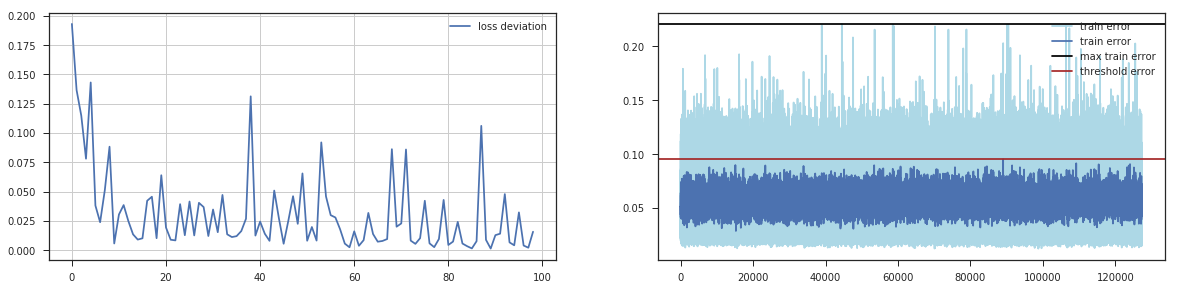

In [14]:
autoencoder, threshold_error = train_autoencoder(traindata)

## Train second autoencoder
![title](Flow_density_anomalies_images/Density anomalities3.png)

** Prepare train datasets for second Autoencoder basing on a set of normal POZMAN traffic **

Only flows which were scored above threshold will be used to train second autoencoder

In [16]:
def detect_above_threshold(hdfs, traffic, features, autoencoder, gen_graphs=True):
    print("Analysing traffic:", traffic)
    
    flows = list(ds.get_flows(hdfs, datasets2[traffic]))
    _testdata, _features = ds.prepare_data(flows, features, flow_modification_f=modify_flow)
    _scoretest = autoencoder.score(_testdata)
    
    flows_above_threshold = [flow for flow, score in zip(flows, _scoretest) if score > threshold_error]
    return flows_above_threshold

In [17]:
flows_above_threshold = []
for name, dataset in datasets2.items():
    result = detect_above_threshold(hdfs, name, features, autoencoder, gen_graphs=False)
    flows_above_threshold += result

Analysing traffic: 0
Skipped flows: 0 from 29168 (0.00%)
Analysing traffic: 1
Skipped flows: 0 from 25478 (0.00%)
Analysing traffic: 2
Skipped flows: 0 from 28006 (0.00%)
Analysing traffic: 3
Skipped flows: 0 from 28214 (0.00%)
Analysing traffic: 4
Skipped flows: 0 from 29129 (0.00%)
Analysing traffic: 5
Skipped flows: 0 from 26067 (0.00%)
Analysing traffic: 6
Skipped flows: 0 from 20046 (0.00%)
Analysing traffic: 7
Skipped flows: 0 from 23812 (0.00%)
Analysing traffic: 8
Skipped flows: 0 from 27830 (0.00%)
Analysing traffic: 9
Skipped flows: 0 from 28182 (0.00%)
Analysing traffic: 10
Skipped flows: 0 from 28181 (0.00%)
Analysing traffic: 11
Skipped flows: 0 from 30630 (0.00%)
Analysing traffic: 12
Skipped flows: 0 from 29624 (0.00%)
Analysing traffic: 13
Skipped flows: 0 from 19083 (0.00%)
Analysing traffic: 14
Skipped flows: 0 from 28041 (0.00%)
Analysing traffic: 15
Skipped flows: 0 from 26709 (0.00%)
Analysing traffic: 16
Skipped flows: 0 from 30738 (0.00%)
Analysing traffic: 17
Sk

** Train second autoencoder **

Input: 22, hidden: 6
...................................................................................................

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


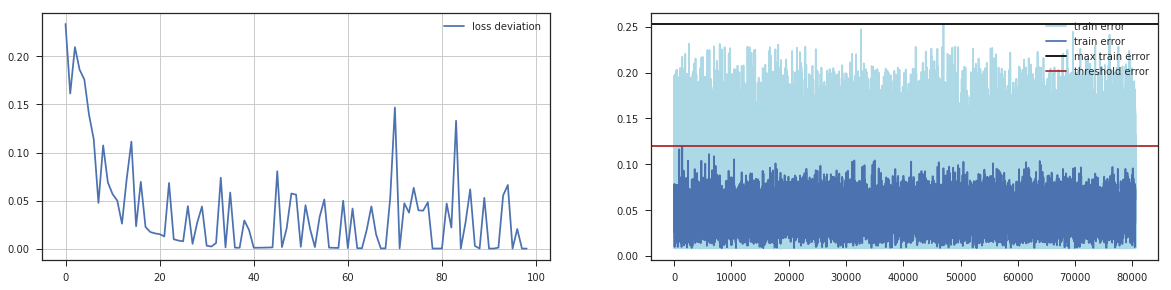

In [18]:
from sklearn.model_selection import train_test_split
train_flows, test_flows = train_test_split(flows_above_threshold, test_size=0.33)

traindata, _features = ds.prepare_data(train_flows, features, flow_modification_f=modify_flow)
autoencoder2, threshold_error2 = train_autoencoder(traindata)

Test second autoencoder score results

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


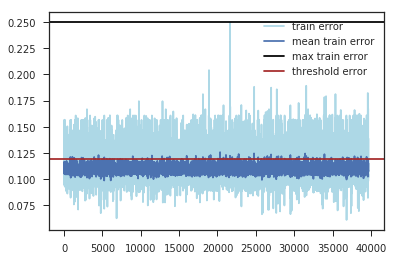

In [19]:
testdata, _features = ds.prepare_data(test_flows, features, flow_modification_f=modify_flow)
scoretrain = autoencoder.score(testdata)
max_scoretrain = max(scoretrain)
    
scoretrain2 = ds.movingaverage(scoretrain, window=10)
#threshold_error2 *= 1.3

plt.plot(scoretrain, color='lightblue', label='train error')
plt.plot(scoretrain2, label='mean train error')
plt.axhline(max_scoretrain, color='black', label='max train error')
plt.axhline(threshold_error2, color='brown', label='threshold error')
plt.legend()
plt.show()

In [20]:
flows_above_threshold2 = [flow for flow, score in zip(test_flows, scoretrain) if score > threshold_error2]
print(len(flows_above_threshold2))

6095


## PCA processing

** Use two trained autoencoders for getting PCA data for flows with score above second autoencoder threshold **

In [21]:
def double_autoencoder_scoring(hdfs, datasets, traffic, features, autoencoder1, autoencoder2, gen_graphs=False):
    start_time = time.time()
    tp_flows, tn_flows, fp_flows, fn_flows = [], [], [], []   
    
    print("Analysing traffic:", traffic)
    
    flows = list(ds.get_flows(hdfs, datasets[traffic]))
    _testdata, _features = ds.prepare_data(flows, features, flow_modification_f=modify_flow)
    _scoretest = autoencoder1.score(_testdata)
    
    _flows_above_threshold = [flow for flow, score in zip(flows, _scoretest) if score > threshold_error]
    
    flows_len, above_len = len(flows), len(_flows_above_threshold)
    print("First AE reduced flow count from %i to %i (%i%%)" % (flows_len, above_len, 100.0*above_len/flows_len))
    
    traindata2, _features = ds.prepare_data(_flows_above_threshold, features, flow_modification_f=modify_flow)
    _scoretest2 = autoencoder2.score(traindata2)
    
    flows_above_threshold = [flow for flow, score in zip(flows, _scoretest2) if score > threshold_error2]
    
    flow_categories, ddos_category, pca_data = cluster2D_and_analyze_flows(flows_above_threshold, features, gen_graphs=True)

    print("--- Execution time was %s seconds ---" % (time.time() - start_time))
    
    return {'pca_data': pca_data}

Analysing traffic: 0
Skipped flows: 0 from 29168 (0.00%)
First AE reduced flow count from 29168 to 8414 (28%)
Number of flow clustered: 662
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


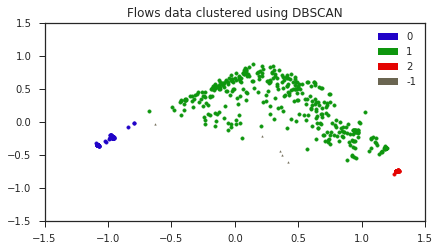

Category id #0 contains 220 flows
             std_dev_payload_byte: 0.0 (98%)
                mean_payload_byte: 0.0 (98%)
                       src_ip_cnt: 1 (86%)
                     dst_port_cnt: 1 (94%)
                 max_payload_byte: 0 (98%)
                 min_payload_byte: 0 (100%)
                     traffic_type: 0 (90%)
                     src_port_cnt: 1 (80%)
            std_dev_packet_length: 0.00-0.01 (85%)
                    total_datalen: 0 (95%)
        byte_distribution_entropy: 0.0 (98%)
                      ip_protocol: 6 (98%)
Category id #1 contains 387 flows
                         pkts_cnt: 1.0-26.5 (79%)
                    total_datalen: 1.0-31683.6 (95%)
                     traffic_type: 0 (92%)
                     src_port_cnt: 1 (80%)
                       src_ip_cnt: 1 (81%)
                     dst_port_cnt: 1 (79%)
                        bytes_cnt: 60.0-32913.7 (94%)
Category id #2 contains 50 flows
                        push_prop: 1.0 

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


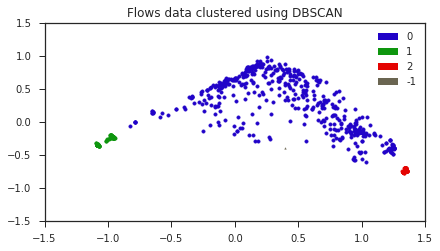

Category id #0 contains 536 flows
                     dst_port_cnt: 1 (81%)
                       src_ip_cnt: 1 (86%)
                     traffic_type: 0.0-0.2 (91%)
                     src_port_cnt: 1.0-1.6 (86%)
                    total_datalen: 8.0-2012.9 (52%)
Category id #1 contains 291 flows
             std_dev_payload_byte: 0.0 (100%)
                mean_payload_byte: 0.0 (100%)
                       src_ip_cnt: 1 (83%)
                     dst_port_cnt: 1 (95%)
                 max_payload_byte: 0 (100%)
                 min_payload_byte: 0 (100%)
                     traffic_type: 0 (89%)
                     src_port_cnt: 1 (82%)
            std_dev_packet_length: 0.0-0.0 (85%)
                    total_datalen: 0 (97%)
        byte_distribution_entropy: 0.0 (100%)
                      ip_protocol: 6 (99%)
Category id #2 contains 84 flows
                        push_prop: 1.0 (100%)
                     traffic_type: 0 (100%)
                     src_port_cnt: 1 (10

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


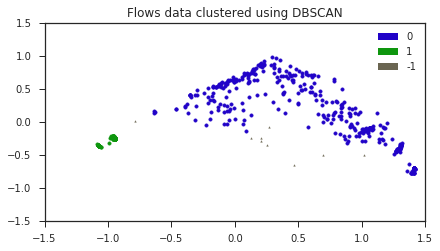

Category id #0 contains 387 flows
                     dst_port_cnt: 1.0-1.1 (76%)
                       src_ip_cnt: 1 (78%)
                     traffic_type: 0 (91%)
                     src_port_cnt: 1 (77%)
Category id #1 contains 173 flows
                 min_payload_byte: 0 (100%)
                    total_datalen: 0 (97%)
                     traffic_type: 0 (91%)
             std_dev_payload_byte: 0.0 (100%)
            std_dev_packet_length: 0.00-0.01 (87%)
                mean_payload_byte: 0.0 (100%)
                       src_ip_cnt: 1 (83%)
                     dst_port_cnt: 1 (90%)
                      ip_protocol: 6 (99%)
                 max_payload_byte: 0 (100%)
        byte_distribution_entropy: 0.0 (100%)
--- Execution time was 6.36412239074707 seconds ---
Analysing traffic: 3
Skipped flows: 0 from 28214 (0.00%)
First AE reduced flow count from 28214 to 5702 (20%)
Number of flow clustered: 619
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


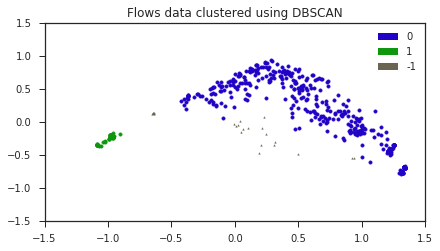

Category id #0 contains 439 flows
                     dst_port_cnt: 1 (77%)
                       src_ip_cnt: 1.0-1.0 (79%)
                     traffic_type: 0 (93%)
                     src_port_cnt: 1.0-1.1 (76%)
Category id #1 contains 156 flows
             std_dev_payload_byte: 0.0 (100%)
                        tcp_flags: 16 (73%)
                mean_payload_byte: 0.0 (98%)
                       src_ip_cnt: 1 (78%)
                     dst_port_cnt: 1 (92%)
                 max_payload_byte: 0 (98%)
        byte_distribution_entropy: 0.0 (99%)
                 min_payload_byte: 0 (98%)
                     traffic_type: 0 (85%)
                     src_port_cnt: 1 (75%)
            std_dev_packet_length: 0.00-0.01 (83%)
                    total_datalen: 0 (96%)
                      ip_protocol: 6 (98%)
--- Execution time was 6.5657172203063965 seconds ---
Analysing traffic: 4
Skipped flows: 0 from 29129 (0.00%)
First AE reduced flow count from 29129 to 6464 (22%)
Number of

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


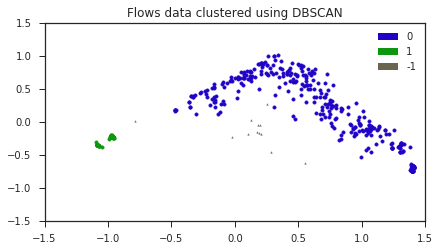

Category id #0 contains 378 flows
                     dst_port_cnt: 1.0-1.1 (78%)
                       src_ip_cnt: 1 (82%)
                     traffic_type: 0 (91%)
                     src_port_cnt: 1.0-1.1 (78%)
Category id #1 contains 176 flows
             std_dev_payload_byte: 0.0 (100%)
                        tcp_flags: 16 (76%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (78%)
                     dst_port_cnt: 1 (97%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (100%)
                 min_payload_byte: 0 (99%)
                     traffic_type: 0 (94%)
                     src_port_cnt: 1 (75%)
            std_dev_packet_length: 0.0-0.0 (86%)
                    total_datalen: 0 (97%)
                      ip_protocol: 6 (99%)
--- Execution time was 6.523103952407837 seconds ---
Analysing traffic: 5
Skipped flows: 0 from 26067 (0.00%)
First AE reduced flow count from 26067 to 6220 (23%)
Number of f

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


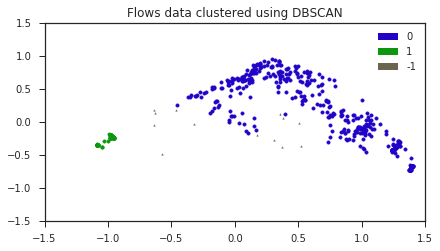

Category id #0 contains 460 flows
                     dst_port_cnt: 1 (79%)
                       src_ip_cnt: 1 (83%)
                     traffic_type: 0 (94%)
                     src_port_cnt: 1.0-1.2 (81%)
Category id #1 contains 193 flows
             std_dev_payload_byte: 0.0 (100%)
                        tcp_flags: 16 (78%)
                mean_payload_byte: 0.0 (100%)
                       src_ip_cnt: 1 (79%)
                     dst_port_cnt: 1 (94%)
                 max_payload_byte: 0 (100%)
        byte_distribution_entropy: 0.0 (100%)
                 min_payload_byte: 0 (100%)
                     traffic_type: 0 (90%)
                     src_port_cnt: 1 (75%)
            std_dev_packet_length: 0.00-0.01 (82%)
                    total_datalen: 0 (97%)
                      ip_protocol: 6 (100%)
--- Execution time was 6.40538215637207 seconds ---
Analysing traffic: 6
Skipped flows: 0 from 20046 (0.00%)
First AE reduced flow count from 20046 to 4728 (23%)
Number of fl

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


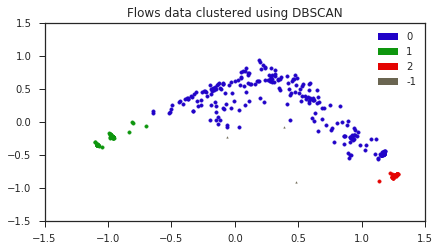

Category id #0 contains 246 flows
                     dst_port_cnt: 1 (80%)
                       src_ip_cnt: 1 (86%)
                     traffic_type: 0 (91%)
                     src_port_cnt: 1 (81%)
                    total_datalen: 1.0-686.3 (52%)
Category id #1 contains 154 flows
             std_dev_payload_byte: 0.0 (98%)
                        tcp_flags: 16 (69%)
                mean_payload_byte: 0.0 (97%)
                       src_ip_cnt: 1 (88%)
                     dst_port_cnt: 1 (95%)
                 max_payload_byte: 0 (97%)
        byte_distribution_entropy: 0.0 (98%)
                 min_payload_byte: 0 (98%)
                     traffic_type: 0 (87%)
                     src_port_cnt: 1 (87%)
            std_dev_packet_length: 0.0 (88%)
                    total_datalen: 0 (92%)
                      ip_protocol: 6 (98%)
Category id #2 contains 30 flows
                        push_prop: 1.0 (96%)
                     traffic_type: 0 (100%)
                   

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


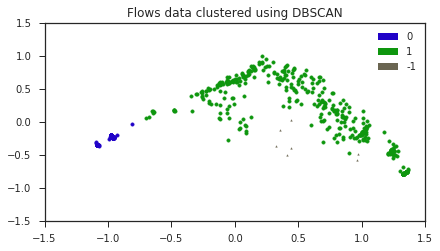

Category id #0 contains 214 flows
             std_dev_payload_byte: 0.0 (99%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (82%)
                     dst_port_cnt: 1 (96%)
                 max_payload_byte: 0 (99%)
                 min_payload_byte: 0 (99%)
                     traffic_type: 0 (86%)
                     src_port_cnt: 1 (78%)
            std_dev_packet_length: 0.00-0.01 (85%)
                    total_datalen: 0 (94%)
        byte_distribution_entropy: 0.0 (99%)
                      ip_protocol: 6 (99%)
Category id #1 contains 435 flows
                     dst_port_cnt: 1 (80%)
                       src_ip_cnt: 1 (83%)
                     traffic_type: 0 (90%)
                     src_port_cnt: 1.0-1.1 (80%)
--- Execution time was 6.11739706993103 seconds ---
Analysing traffic: 8
Skipped flows: 0 from 27830 (0.00%)
First AE reduced flow count from 27830 to 6382 (22%)
Number of flow clustered: 874
PCA 2D dimentions variances: [ 0

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


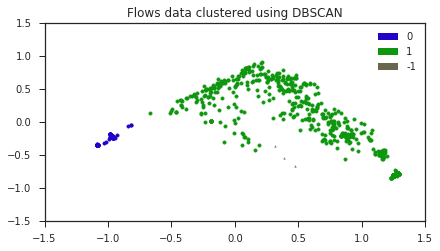

Category id #0 contains 258 flows
             std_dev_payload_byte: 0.0 (98%)
                        tcp_flags: 16 (79%)
                mean_payload_byte: 0.0 (98%)
                       src_ip_cnt: 1 (71%)
                     dst_port_cnt: 1 (93%)
                 max_payload_byte: 0 (98%)
        byte_distribution_entropy: 0.0 (98%)
                 min_payload_byte: 0 (99%)
                     traffic_type: 0 (88%)
                     src_port_cnt: 1 (67%)
            std_dev_packet_length: 0.00-0.01 (75%)
                    total_datalen: 0 (95%)
                      ip_protocol: 6 (98%)
Category id #1 contains 613 flows
                     dst_port_cnt: 1.0-1.1 (77%)
                       src_ip_cnt: 1.0-1.0 (81%)
                     traffic_type: 0 (93%)
                     src_port_cnt: 1.0-1.8 (86%)
--- Execution time was 7.239437103271484 seconds ---
Analysing traffic: 9
Skipped flows: 0 from 28182 (0.00%)
First AE reduced flow count from 28182 to 6221 (22%)
Numbe

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


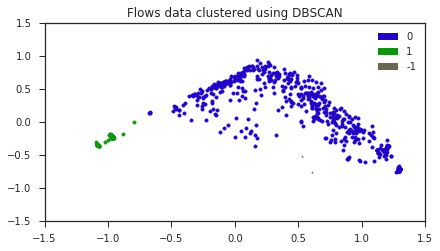

Category id #0 contains 635 flows
                         pkts_cnt: 1.0-21.8 (72%)
                     dst_port_cnt: 1.0-1.2 (79%)
                       src_ip_cnt: 1 (82%)
                     traffic_type: 0 (88%)
                     src_port_cnt: 1.0-2.1 (91%)
Category id #1 contains 238 flows
             std_dev_payload_byte: 0.0 (99%)
                        tcp_flags: 16 (81%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (76%)
                     dst_port_cnt: 1 (93%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (99%)
                 min_payload_byte: 0 (100%)
                     traffic_type: 0 (90%)
                     src_port_cnt: 1 (73%)
            std_dev_packet_length: 0.00-0.01 (82%)
                    total_datalen: 0 (97%)
                      ip_protocol: 6 (99%)
--- Execution time was 7.313571214675903 seconds ---
Analysing traffic: 10
Skipped flows: 0 from 28181 (0.00%)
First AE red

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


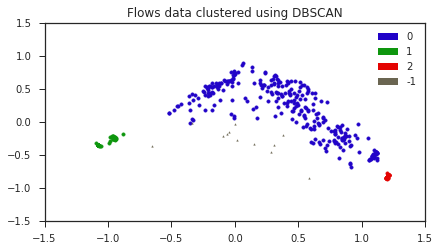

Category id #0 contains 305 flows
                         pkts_cnt: 1.0-55.1 (89%)
                     dst_port_cnt: 1 (74%)
                       src_ip_cnt: 1 (78%)
                     traffic_type: 0 (92%)
                     src_port_cnt: 1.0-1.3 (73%)
Category id #1 contains 195 flows
             std_dev_payload_byte: 0.0 (99%)
                        tcp_flags: 16 (81%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (84%)
                     dst_port_cnt: 1 (95%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (99%)
                 min_payload_byte: 0 (100%)
                     traffic_type: 0 (88%)
                     src_port_cnt: 1 (81%)
            std_dev_packet_length: 0.00-0.01 (83%)
                    total_datalen: 0 (96%)
                      ip_protocol: 6 (99%)
Category id #2 contains 62 flows
                max_packet_length: 1458 (87%)
                        push_prop: 1.0 (100%)
    

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


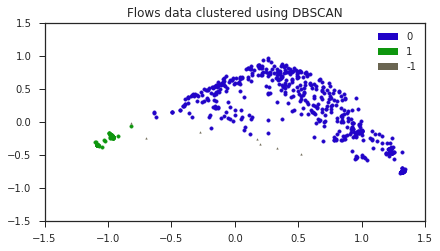

Category id #0 contains 595 flows
                     dst_port_cnt: 1 (79%)
                       src_ip_cnt: 1 (81%)
                     traffic_type: 0 (93%)
                     src_port_cnt: 1.0-1.1 (79%)
Category id #1 contains 253 flows
             std_dev_payload_byte: 0.0 (99%)
                        tcp_flags: 16 (77%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (81%)
                     dst_port_cnt: 1 (96%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (99%)
                 min_payload_byte: 0 (100%)
                     traffic_type: 0 (86%)
                     src_port_cnt: 1 (73%)
            std_dev_packet_length: 0.00-0.01 (86%)
                    total_datalen: 0 (94%)
                      ip_protocol: 6 (98%)
--- Execution time was 8.027422189712524 seconds ---
Analysing traffic: 12
Skipped flows: 0 from 29624 (0.00%)
First AE reduced flow count from 29624 to 6446 (21%)
Number of flow 

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


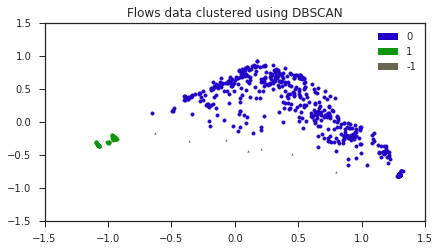

Category id #0 contains 581 flows
                         pkts_cnt: 1.0-22.8 (72%)
                    total_datalen: 4.0-29642.0 (92%)
                     traffic_type: 0 (92%)
                     src_port_cnt: 1.0-1.8 (86%)
                       src_ip_cnt: 1 (81%)
                     dst_port_cnt: 1 (77%)
                        bytes_cnt: 60.0-31223.0 (90%)
Category id #1 contains 225 flows
             std_dev_payload_byte: 0.0 (100%)
                mean_payload_byte: 0.0 (100%)
                       src_ip_cnt: 1 (82%)
                     dst_port_cnt: 1 (96%)
                 max_payload_byte: 0 (100%)
                 min_payload_byte: 0 (100%)
                     traffic_type: 0 (89%)
                     src_port_cnt: 1 (76%)
            std_dev_packet_length: 0.0-0.0 (82%)
                    total_datalen: 0 (97%)
        byte_distribution_entropy: 0.0 (100%)
                      ip_protocol: 6 (100%)
--- Execution time was 7.38037109375 seconds ---
Analysing traf

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


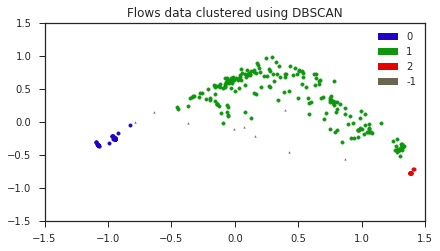

Category id #0 contains 87 flows
             std_dev_payload_byte: 0.0 (97%)
                mean_payload_byte: 0.0 (97%)
                       src_ip_cnt: 1 (90%)
                     dst_port_cnt: 1 (98%)
                 max_payload_byte: 0 (97%)
                 min_payload_byte: 0 (100%)
                     traffic_type: 0 (85%)
                     src_port_cnt: 1 (81%)
            std_dev_packet_length: 0.0 (87%)
                    total_datalen: 0 (96%)
        byte_distribution_entropy: 0.0 (97%)
                      ip_protocol: 6 (98%)
Category id #1 contains 208 flows
                         pkts_cnt: 1.0-9.9 (62%)
                    total_datalen: 6.0-12092.6 (77%)
                     traffic_type: 0 (88%)
                     src_port_cnt: 1 (81%)
                       src_ip_cnt: 1 (84%)
                     dst_port_cnt: 1 (85%)
                        bytes_cnt: 69.0-12776.0 (74%)
Category id #2 contains 14 flows
                        tcp_flags: 24 (100%)
  

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


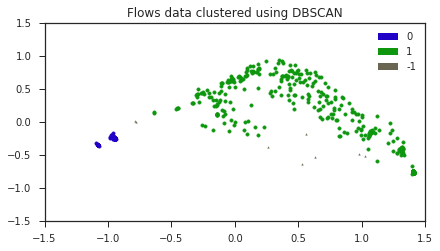

Category id #0 contains 172 flows
             std_dev_payload_byte: 0.0 (100%)
                mean_payload_byte: 0.0 (98%)
                       src_ip_cnt: 1 (81%)
                     dst_port_cnt: 1 (96%)
                 max_payload_byte: 0 (98%)
                 min_payload_byte: 0 (98%)
                     traffic_type: 0 (86%)
                     src_port_cnt: 1 (76%)
            std_dev_packet_length: 0.00-0.01 (86%)
                    total_datalen: 0 (95%)
        byte_distribution_entropy: 0.0 (99%)
                      ip_protocol: 6 (98%)
Category id #1 contains 370 flows
                     dst_port_cnt: 1 (77%)
                       src_ip_cnt: 1 (82%)
                     traffic_type: 0 (92%)
                     src_port_cnt: 1.0-1.3 (77%)
--- Execution time was 6.32815408706665 seconds ---
Analysing traffic: 15
Skipped flows: 0 from 26709 (0.00%)
First AE reduced flow count from 26709 to 5721 (21%)
Number of flow clustered: 474
PCA 2D dimentions variances: [

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


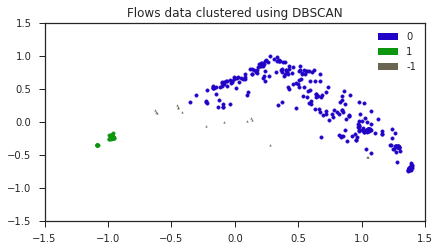

Category id #0 contains 307 flows
                         pkts_cnt: 1.0-18.9 (72%)
                    total_datalen: 8.0-24667.6 (92%)
                     traffic_type: 0 (93%)
                     src_port_cnt: 1 (78%)
                       src_ip_cnt: 1 (83%)
                     dst_port_cnt: 1 (79%)
                        bytes_cnt: 60.0-25756.6 (83%)
Category id #1 contains 152 flows
             std_dev_payload_byte: 0.0 (100%)
                        tcp_flags: 16 (84%)
                mean_payload_byte: 0.0 (98%)
                       src_ip_cnt: 1 (78%)
                     dst_port_cnt: 1 (96%)
                 max_payload_byte: 0 (98%)
        byte_distribution_entropy: 0.0 (99%)
                 min_payload_byte: 0 (98%)
                     traffic_type: 0 (87%)
                     src_port_cnt: 1 (73%)
            std_dev_packet_length: 0.00-0.01 (78%)
                    total_datalen: 0 (96%)
                      ip_protocol: 6 (98%)
--- Execution time was 5.912

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


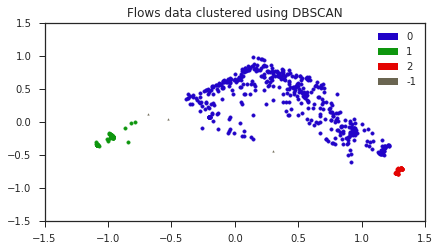

Category id #0 contains 466 flows
                         pkts_cnt: 1.0-13.2 (60%)
                    total_datalen: 1.0-17072.8 (77%)
                     traffic_type: 0 (90%)
                     src_port_cnt: 1.0-1.4 (73%)
                       src_ip_cnt: 1 (77%)
                     dst_port_cnt: 1 (74%)
                        bytes_cnt: 60.0-17985.5 (75%)
Category id #1 contains 226 flows
             std_dev_payload_byte: 0.0 (98%)
                        tcp_flags: 16 (78%)
                mean_payload_byte: 0.0 (98%)
                       src_ip_cnt: 1 (80%)
                     dst_port_cnt: 1 (95%)
                 max_payload_byte: 0 (98%)
        byte_distribution_entropy: 0.0 (98%)
                 min_payload_byte: 0 (99%)
                     traffic_type: 0 (85%)
                     src_port_cnt: 1 (76%)
            std_dev_packet_length: 0.00-0.01 (83%)
                    total_datalen: 0 (97%)
                      ip_protocol: 6 (99%)
Category id #2 contains

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


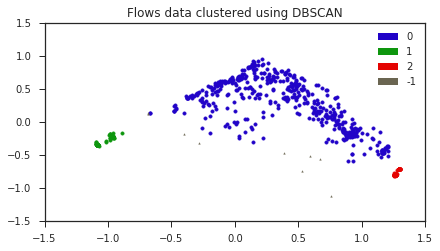

Category id #0 contains 489 flows
                    total_datalen: 1.0-2106.1 (60%)
                     traffic_type: 0 (90%)
                     src_port_cnt: 1.0-1.1 (76%)
                       src_ip_cnt: 1 (78%)
                     dst_port_cnt: 1 (72%)
                        bytes_cnt: 60.0-2255.2 (55%)
Category id #1 contains 247 flows
             std_dev_payload_byte: 0.0 (100%)
                        tcp_flags: 16 (74%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (80%)
                     dst_port_cnt: 1 (95%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (99%)
                 min_payload_byte: 0 (99%)
                     traffic_type: 0 (86%)
                     src_port_cnt: 1 (78%)
            std_dev_packet_length: 0.0-0.0 (87%)
                    total_datalen: 0 (95%)
                      ip_protocol: 6 (99%)
                        bytes_cnt: 60.0-1576.2 (72%)
Category id #2 contains

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


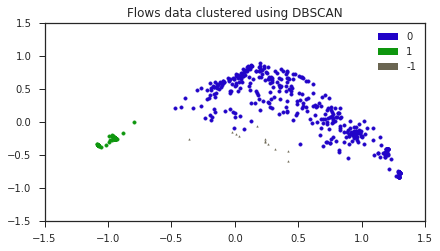

Category id #0 contains 438 flows
                     dst_port_cnt: 1 (72%)
                       src_ip_cnt: 1 (79%)
                     traffic_type: 0 (93%)
                     src_port_cnt: 1.0-1.2 (74%)
Category id #1 contains 178 flows
             std_dev_payload_byte: 0.0 (98%)
                        tcp_flags: 16 (77%)
                mean_payload_byte: 0.0 (98%)
                       src_ip_cnt: 1 (78%)
                     dst_port_cnt: 1 (93%)
                 max_payload_byte: 0 (98%)
        byte_distribution_entropy: 0.0 (98%)
                 min_payload_byte: 0 (100%)
                     traffic_type: 0 (88%)
                     src_port_cnt: 1 (73%)
            std_dev_packet_length: 0.0-0.0 (83%)
                    total_datalen: 0 (96%)
                      ip_protocol: 6 (98%)
--- Execution time was 6.417510747909546 seconds ---


In [28]:
above_threshold_data = {}
for name, dataset in datasets2.items():
    result = double_autoencoder_scoring(hdfs, datasets2, name, features, autoencoder, autoencoder2, gen_graphs=False)
    above_threshold_data[name] = result['pca_data']

## Testing Isolation Forest for novelity detection

Train and test Isolation Forest

In [31]:
above_threshold_train = np.concatenate(list(above_threshold_data.values())[:10], axis=0)

from sklearn.ensemble import IsolationForest
from sklearn import svm

isol_forest = IsolationForest(max_samples=len(above_threshold_train), contamination=0.01)
#isol_forest = svm.OneClassSVM()
isol_forest.fit(above_threshold_train)
y_pred_train = isol_forest.predict(above_threshold_train)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


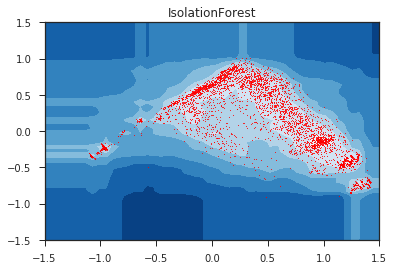

In [32]:
# plot the line, the samples, and the nearest vectors to the plane
border = 1.5
xx, yy = np.meshgrid(np.linspace(-border, border, 50), np.linspace(-border, border, 50))
Z = isol_forest.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
plt.scatter(above_threshold_train[:, 0], above_threshold_train[:, 1], c='red', s=0.5)

** Validate Isolation Forest by searching novelities in various traffic datasets **

In [33]:
def seach_novelities(classifier, data, name):
    data_prediction = classifier.predict(data)
    
    inliners = [d for d, pred in zip(data, data_prediction) if pred == 1]
    outliers = [d for d, pred in zip(data, data_prediction) if pred == -1]
    inliners = np.array(inliners)
    outliers = np.array(outliers)
    
    border = 1.5
    xx, yy = np.meshgrid(np.linspace(-border, border, 50), np.linspace(-border, border, 50))
    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    plt.scatter(inliners[:, 0], inliners[:, 1], c='red', s=0.5)
    plt.scatter(outliers[:, 0], outliers[:, 1], c='black', s=1.5)
    plt.title(name)
    plt.show()

Validate Isolation Forest for dataset with only normal traffic

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


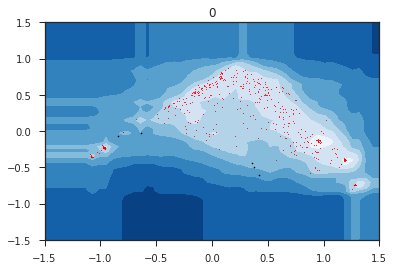

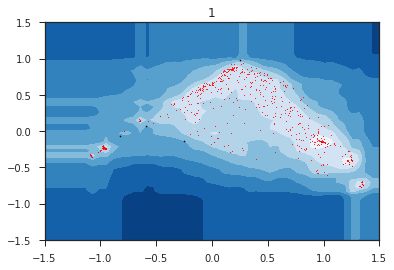

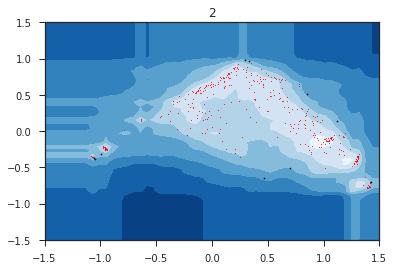

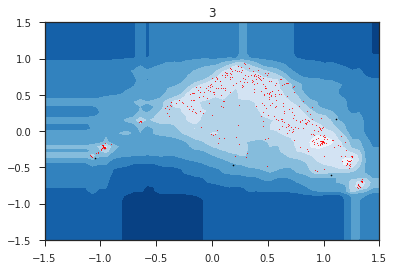

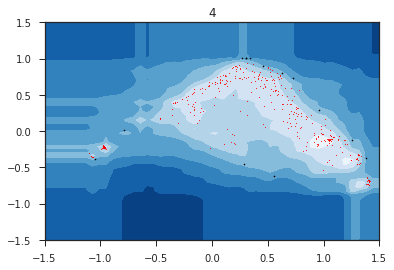

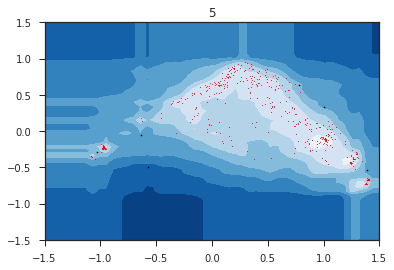

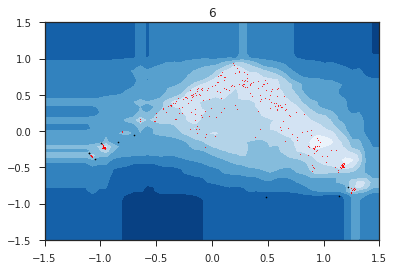

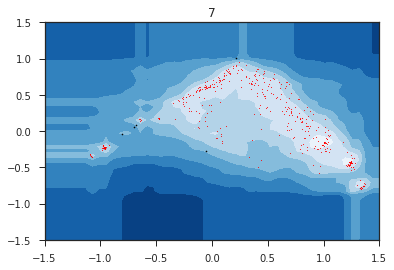

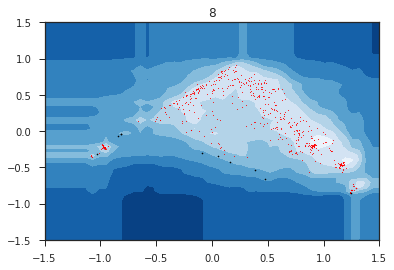

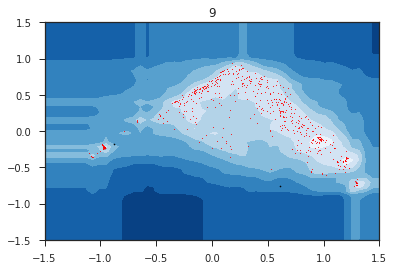

In [36]:
for name, data in list(above_threshold_data.items())[:10]:
    seach_novelities(isol_forest, data, "Traffic id: " + name)

Validate Isolation Forest for datasets with DDoS attacks

Analysing traffic: Pozman+SYNflood-HTTP
Skipped flows: 0 from 200601 (0.00%)
First AE reduced flow count from 200601 to 178649 (89%)
Number of flow clustered: 172954
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


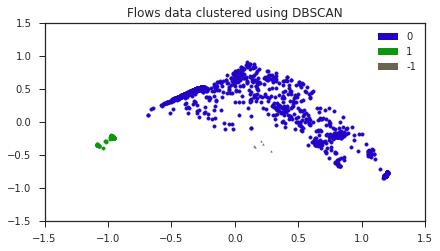

Category id #0 contains 9572 flows
                max_packet_length: 65.7-67.2 (92%)
                 min_payload_byte: 0.7-0.9 (92%)
                    total_datalen: 10.0-17047.0 (97%)
                        tcp_flags: 2 (92%)
                     dst_port_cnt: 1 (98%)
               mean_packet_length: 65.7-67.1 (92%)
                         pkts_cnt: 1.0-13.5 (95%)
                     traffic_type: 192 (92%)
                     src_port_cnt: 1 (98%)
                min_packet_length: 65.7-67.1 (92%)
            std_dev_packet_length: 0.0-0.7 (94%)
                         syn_prop: 1.0 (92%)
                      ip_protocol: 6 (97%)
                        bytes_cnt: 68.0-17979.4 (96%)
Category id #1 contains 423 flows
                 min_payload_byte: 0 (100%)
             std_dev_payload_byte: 0.0 (100%)
                        tcp_flags: 16 (89%)
                mean_payload_byte: 0.0 (100%)
                       src_ip_cnt: 1 (77%)
                     dst_port_cnt: 1 

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


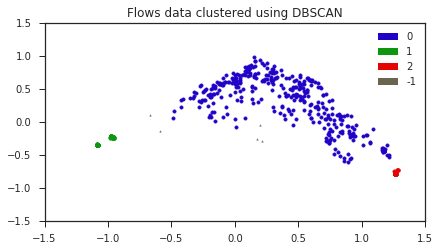

Category id #0 contains 384 flows
                         pkts_cnt: 1.0-29.5 (70%)
                    total_datalen: 1.0-39341.4 (90%)
                     traffic_type: 0 (91%)
                     src_port_cnt: 1.0-1.1 (76%)
                       src_ip_cnt: 1 (77%)
                     dst_port_cnt: 1 (76%)
                        bytes_cnt: 60.0-41053.9 (88%)
Category id #1 contains 188 flows
             std_dev_payload_byte: 0.0 (100%)
                mean_payload_byte: 0.0 (100%)
                       src_ip_cnt: 1 (87%)
                     dst_port_cnt: 1 (93%)
                 max_payload_byte: 0 (100%)
                 min_payload_byte: 0 (100%)
                     traffic_type: 0 (94%)
                     src_port_cnt: 1 (79%)
            std_dev_packet_length: 0.00-0.01 (75%)
                    total_datalen: 0 (99%)
        byte_distribution_entropy: 0.0 (100%)
                      ip_protocol: 6 (100%)
Category id #2 contains 47 flows
                 min_payload

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


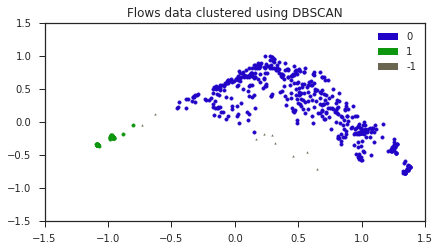

Category id #0 contains 514 flows
                         pkts_cnt: 1.0-29.5 (72%)
                    total_datalen: 17.0-39379.6 (91%)
                     traffic_type: 0 (96%)
                     src_port_cnt: 1.0-1.1 (79%)
                       src_ip_cnt: 1.0-1.0 (81%)
                     dst_port_cnt: 1.0-1.7 (90%)
                        bytes_cnt: 66.0-41083.6 (89%)
Category id #1 contains 259 flows
             std_dev_payload_byte: 0.0 (99%)
                        tcp_flags: 16 (79%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (82%)
                     dst_port_cnt: 1 (94%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (99%)
                 min_payload_byte: 0 (100%)
                     traffic_type: 0 (92%)
                     src_port_cnt: 1 (76%)
            std_dev_packet_length: 0.00-0.01 (82%)
                    total_datalen: 0 (98%)
                      ip_protocol: 6 (99%)
--- Execu

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


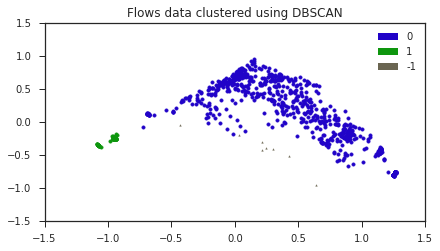

Category id #0 contains 784 flows
                         pkts_cnt: 1.0-22.3 (68%)
                    total_datalen: 1.0-30495.6 (90%)
                     traffic_type: 0 (94%)
                     src_port_cnt: 1.0-1.1 (81%)
                       src_ip_cnt: 1 (82%)
                     dst_port_cnt: 1.0-2.0 (92%)
                        bytes_cnt: 60.0-31789.7 (89%)
Category id #1 contains 362 flows
                 min_payload_byte: 0 (99%)
             std_dev_payload_byte: 0.0 (100%)
                        tcp_flags: 16 (77%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (85%)
                     dst_port_cnt: 1 (97%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (100%)
                         pkts_cnt: 1.0-44.2 (80%)
                     traffic_type: 0 (93%)
                     src_port_cnt: 1 (75%)
            std_dev_packet_length: 0.0-0.0 (80%)
                    total_datalen: 0 (97%)
          

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


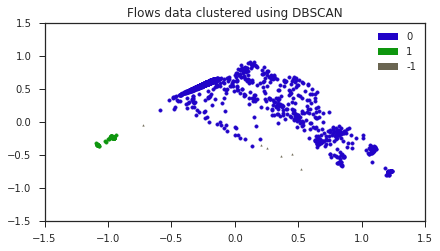

Category id #0 contains 9664 flows
                max_packet_length: 68.0-69.4 (93%)
                 min_payload_byte: 0.8-0.9 (94%)
                         rst_prop: 1.0 (93%)
                        tcp_flags: 4 (93%)
               mean_packet_length: 66.3-67.7 (93%)
                         pkts_cnt: 1.0-13.8 (96%)
                     traffic_type: 192 (93%)
                        bytes_cnt: 71.0-18449.6 (97%)
            std_dev_packet_length: 0.0-0.7 (94%)
                    total_datalen: 1.0-17638.4 (98%)
                      ip_protocol: 6 (97%)
                min_packet_length: 65.6-67.1 (93%)
Category id #1 contains 330 flows
             std_dev_payload_byte: 0.0 (100%)
                        tcp_flags: 16 (90%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (81%)
                     dst_port_cnt: 1 (96%)
                 max_payload_byte: 0 (99%)
                 min_payload_byte: 0 (99%)
                     traffic_type: 0 (97

/home/jovyan/work/dataset_utils2.py:342: RuntimeWarning: invalid value encountered in true_divide
  scalled = high - (((high - low) * (maxs - rawpoints)) / rng)  # throws warnings divide by zero


First AE reduced flow count from 24576 to 23170 (94%)
Number of flow clustered: 23136
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


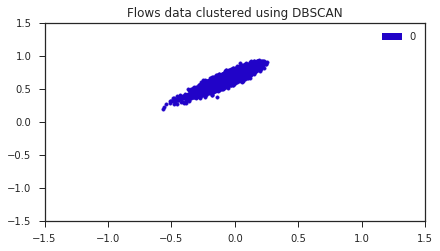

Category id #0 contains 10000 flows
                max_packet_length: 68 (100%)
                 min_payload_byte: 1 (98%)
                     traffic_type: 192 (100%)
                     src_port_cnt: 1 (100%)
                        tcp_flags: 2 (100%)
                min_packet_length: 68 (100%)
            std_dev_packet_length: 0.0 (100%)
                         syn_prop: 1.0 (100%)
                     dst_port_cnt: 1 (100%)
                      ip_protocol: 6 (100%)
               mean_packet_length: 68.0 (100%)
--- Execution time was 68.87343788146973 seconds ---
Analysing traffic: Pozman+SYNflood-HTTP-2b
Skipped flows: 0 from 37144 (0.00%)
First AE reduced flow count from 37144 to 13622 (36%)
Number of flow clustered: 6577
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


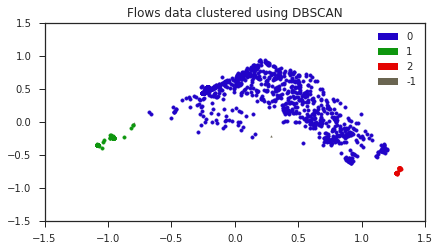

Category id #0 contains 6081 flows
                max_packet_length: 65.8-67.2 (87%)
                        tcp_flags: 2 (87%)
                     dst_port_cnt: 1 (96%)
               mean_packet_length: 65.7-67.2 (87%)
                 max_payload_byte: 255 (95%)
                 min_payload_byte: 0.7-0.9 (90%)
                     traffic_type: 192 (87%)
                        bytes_cnt: 24389.3-32499.1 (84%)
                min_packet_length: 65.7-67.2 (87%)
            std_dev_packet_length: 0.0-0.7 (90%)
                    total_datalen: 14.0-7728.2 (95%)
                      ip_protocol: 6 (94%)
                     src_port_cnt: 1 (96%)
Category id #1 contains 461 flows
                 min_payload_byte: 0 (100%)
             std_dev_payload_byte: 0.0 (99%)
                        tcp_flags: 16 (84%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (86%)
                     dst_port_cnt: 1 (97%)
                 max_payload_byte: 0 (99%)
 

/home/jovyan/work/dataset_utils2.py:342: RuntimeWarning: invalid value encountered in true_divide
  scalled = high - (((high - low) * (maxs - rawpoints)) / rng)  # throws warnings divide by zero


First AE reduced flow count from 172031 to 143859 (83%)
Number of flow clustered: 143729
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


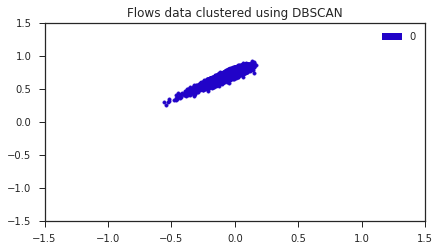

Category id #0 contains 10000 flows
                max_packet_length: 68 (100%)
                 min_payload_byte: 1 (99%)
                     traffic_type: 192 (100%)
                     src_port_cnt: 1 (100%)
                        tcp_flags: 2 (100%)
                min_packet_length: 68 (100%)
            std_dev_packet_length: 0.0 (100%)
                         syn_prop: 1.0 (100%)
                     dst_port_cnt: 1 (100%)
                      ip_protocol: 6 (100%)
               mean_packet_length: 68.0 (100%)
--- Execution time was 102.50186967849731 seconds ---
Analysing traffic: Pozman+SYNfloodFIN
Skipped flows: 0 from 200133 (0.00%)
First AE reduced flow count from 200133 to 178533 (89%)
Number of flow clustered: 172926
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


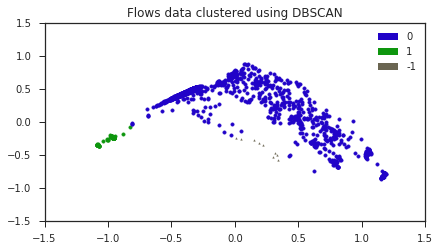

Category id #0 contains 9648 flows
                max_packet_length: 65.7-67.2 (93%)
                 min_payload_byte: 0.7-0.9 (95%)
                    total_datalen: 20.0-17646.5 (98%)
                        tcp_flags: 3 (93%)
                         fin_prop: 1.0 (93%)
               mean_packet_length: 65.7-67.2 (93%)
                         pkts_cnt: 1.0-13.3 (96%)
                     traffic_type: 192 (93%)
                        bytes_cnt: 82.0-18422.3 (98%)
            std_dev_packet_length: 0.0-0.7 (95%)
                         syn_prop: 1.0 (93%)
                      ip_protocol: 6 (98%)
                min_packet_length: 65.7-67.2 (93%)
Category id #1 contains 343 flows
                 min_payload_byte: 0 (99%)
             std_dev_payload_byte: 0.0 (99%)
                        tcp_flags: 16 (85%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (79%)
                     dst_port_cnt: 1 (97%)
                 max_payload_byte: 0 (

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


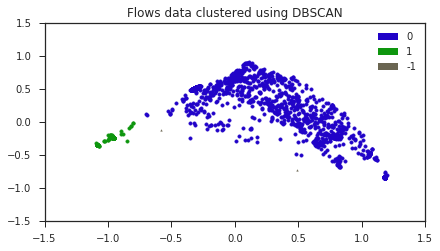

Category id #0 contains 9481 flows
                max_packet_length: 65.8-67.2 (87%)
                        tcp_flags: 2 (87%)
                     dst_port_cnt: 1 (97%)
               mean_packet_length: 65.7-67.2 (87%)
                 min_payload_byte: 0.5-0.8 (90%)
                     traffic_type: 192 (87%)
                        bytes_cnt: 82.0-28403.8 (97%)
                min_packet_length: 65.7-67.2 (87%)
            std_dev_packet_length: 0.0-0.8 (90%)
                    total_datalen: 8.0-27227.4 (98%)
                      ip_protocol: 6 (96%)
                     src_port_cnt: 1 (98%)
Category id #1 contains 517 flows
                 min_payload_byte: 0 (99%)
             std_dev_payload_byte: 0.0 (98%)
                        tcp_flags: 16 (86%)
                mean_payload_byte: 0.0 (98%)
                       src_ip_cnt: 1 (78%)
                     dst_port_cnt: 1 (95%)
                 max_payload_byte: 0 (98%)
        byte_distribution_entropy: 0.0 (98%)
     

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


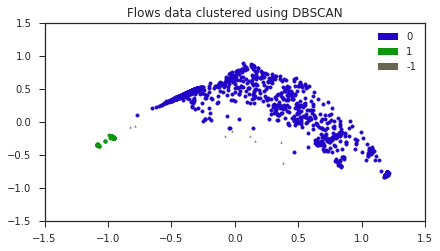

Category id #0 contains 9606 flows
                max_packet_length: 66.4-67.8 (93%)
                 min_payload_byte: 0.7-0.9 (95%)
                    total_datalen: 30.0-10123.6 (97%)
                         rst_prop: 1.0 (93%)
                        tcp_flags: 6 (93%)
               mean_packet_length: 66.1-67.6 (93%)
                         pkts_cnt: 1.0-8.8 (90%)
                     traffic_type: 192 (93%)
                        bytes_cnt: 94.0-10707.8 (96%)
            std_dev_packet_length: 0.0-0.7 (94%)
                         syn_prop: 1.0 (93%)
                      ip_protocol: 6 (97%)
                min_packet_length: 65.7-67.2 (93%)
Category id #1 contains 386 flows
             std_dev_payload_byte: 0.0 (100%)
                        tcp_flags: 16 (87%)
                mean_payload_byte: 0.0 (100%)
                       src_ip_cnt: 1 (74%)
                     dst_port_cnt: 1 (97%)
                 max_payload_byte: 0 (100%)
                 min_payload_byte: 0

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


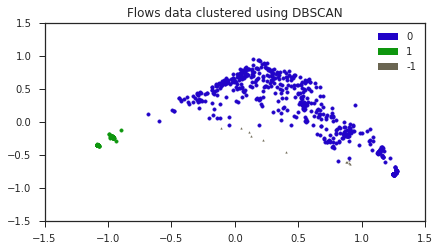

Category id #0 contains 566 flows
                     dst_port_cnt: 1.0-1.0 (79%)
                       src_ip_cnt: 1 (82%)
                     traffic_type: 0 (94%)
                     src_port_cnt: 1.0-1.0 (81%)
Category id #1 contains 254 flows
             std_dev_payload_byte: 0.0 (99%)
                        tcp_flags: 16 (76%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (85%)
                     dst_port_cnt: 1 (95%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (99%)
                 min_payload_byte: 0 (100%)
                     traffic_type: 0 (92%)
                     src_port_cnt: 1 (79%)
            std_dev_packet_length: 0.0-0.0 (81%)
                    total_datalen: 0 (97%)
                      ip_protocol: 6 (99%)
--- Execution time was 7.181347608566284 seconds ---
Analysing traffic: Pozman-6
Skipped flows: 0 from 30671 (0.00%)
First AE reduced flow count from 30671 to 8032 (26%)
Numbe

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


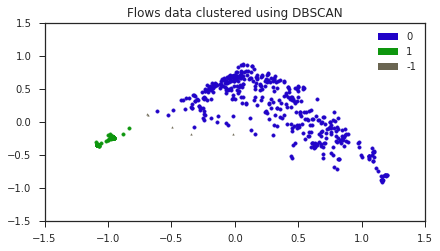

Category id #0 contains 429 flows
                         pkts_cnt: 1.0-24.2 (67%)
                    total_datalen: 3.0-29963.8 (87%)
                     traffic_type: 0 (90%)
                     src_port_cnt: 1.0-2.5 (91%)
                       src_ip_cnt: 1 (79%)
                     dst_port_cnt: 1 (77%)
                        bytes_cnt: 62.0-31559.7 (85%)
Category id #1 contains 200 flows
                 min_payload_byte: 0 (100%)
             std_dev_payload_byte: 0.0 (99%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (87%)
                     dst_port_cnt: 1 (94%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (99%)
                         pkts_cnt: 1.0-6.2 (51%)
                     traffic_type: 0 (94%)
                     src_port_cnt: 1 (75%)
            std_dev_packet_length: 0.0-0.0 (77%)
                    total_datalen: 0 (96%)
                      ip_protocol: 6 (98%)
                   

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


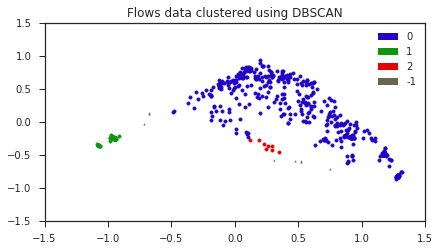

Category id #0 contains 474 flows
                         pkts_cnt: 1.0-21.5 (72%)
                    total_datalen: 1.0-29427.2 (92%)
                     traffic_type: 0 (95%)
                     src_port_cnt: 1 (82%)
                       src_ip_cnt: 1 (83%)
                     dst_port_cnt: 1 (80%)
                        bytes_cnt: 60.0-30678.0 (91%)
Category id #1 contains 239 flows
             std_dev_payload_byte: 0.0 (100%)
                        tcp_flags: 16 (76%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (86%)
                     dst_port_cnt: 1 (93%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (100%)
                 min_payload_byte: 0 (99%)
                     traffic_type: 0 (94%)
                     src_port_cnt: 1 (77%)
            std_dev_packet_length: 0.00-0.01 (84%)
                    total_datalen: 0 (98%)
                      ip_protocol: 6 (99%)
Category id #2 contains 8 f

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


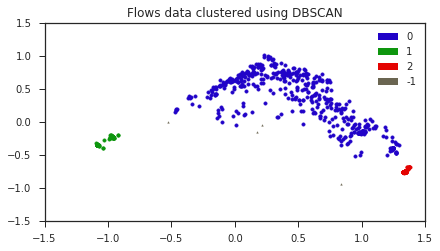

Category id #0 contains 494 flows
                    total_datalen: 3.0-4004.6 (66%)
                     traffic_type: 0 (93%)
                     src_port_cnt: 1 (81%)
                       src_ip_cnt: 1 (85%)
                     dst_port_cnt: 1 (81%)
                        bytes_cnt: 60.0-4191.0 (60%)
Category id #1 contains 256 flows
             std_dev_payload_byte: 0.0 (100%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (80%)
                     dst_port_cnt: 1 (94%)
                 max_payload_byte: 0 (99%)
                 min_payload_byte: 0 (99%)
                     traffic_type: 0 (92%)
                     src_port_cnt: 1 (75%)
            std_dev_packet_length: 0.0-0.0 (85%)
                    total_datalen: 0 (96%)
        byte_distribution_entropy: 0.0 (100%)
                      ip_protocol: 6 (100%)
Category id #2 contains 72 flows
                        push_prop: 1.0 (100%)
                     traffic_type: 0 (100%)
 

In [37]:
above_threshold_data2 = {}
for name, dataset in datasets.items():
    result = double_autoencoder_scoring(hdfs, datasets, name, features, autoencoder, autoencoder2, gen_graphs=False)
    above_threshold_data2[name] = result['pca_data']

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


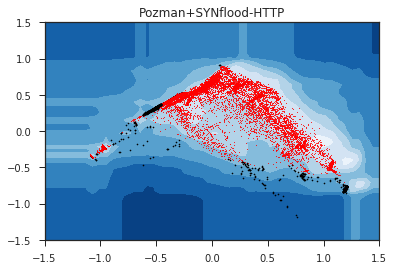

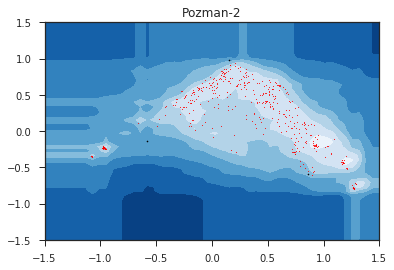

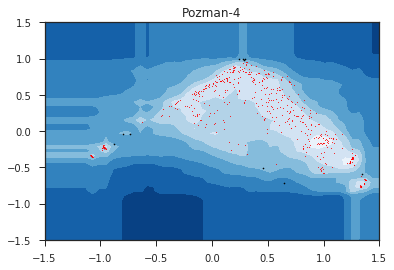

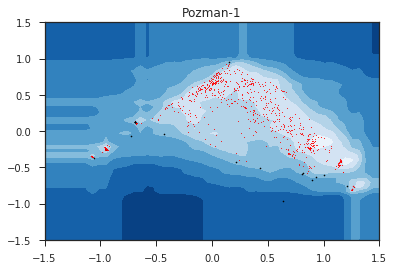

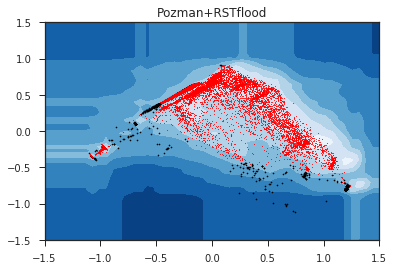

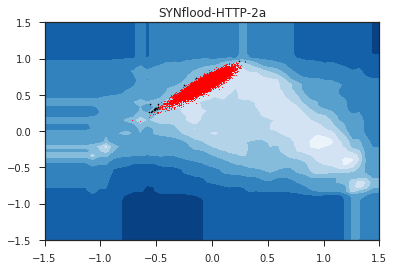

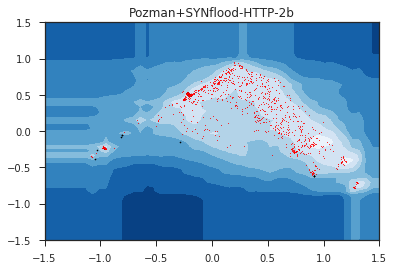

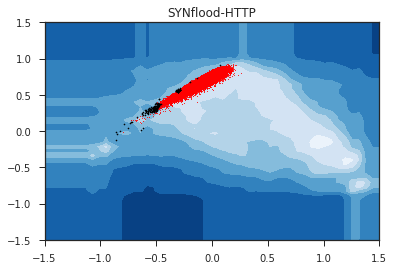

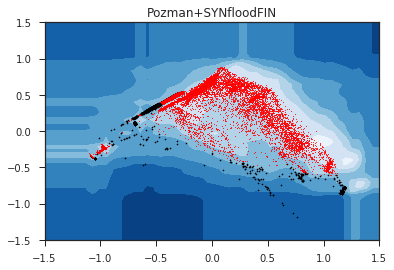

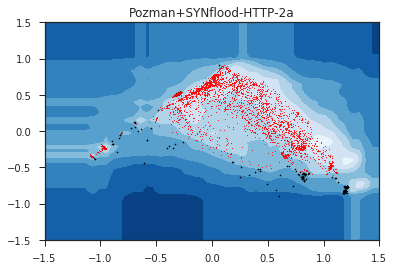

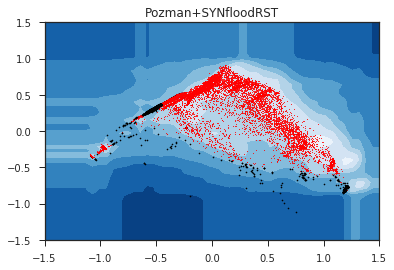

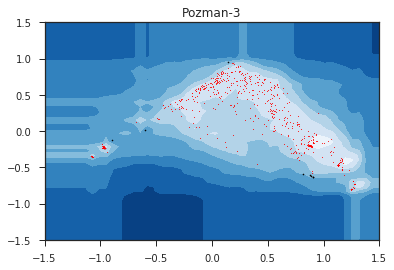

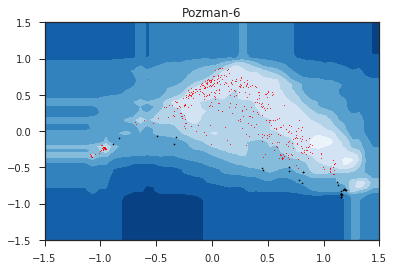

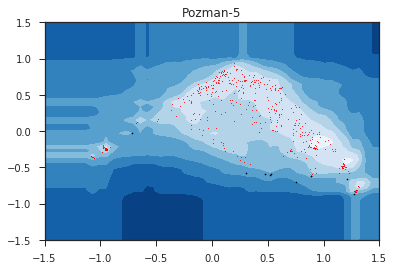

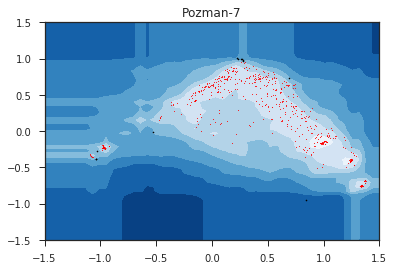

In [38]:
for name, data in above_threshold_data2.items():
    seach_novelities(isol_forest, data, name)

## Test Kernel Density visualisation

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


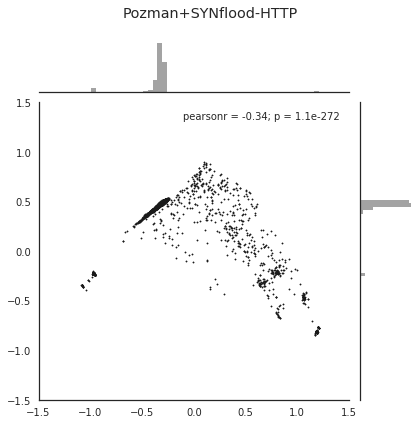

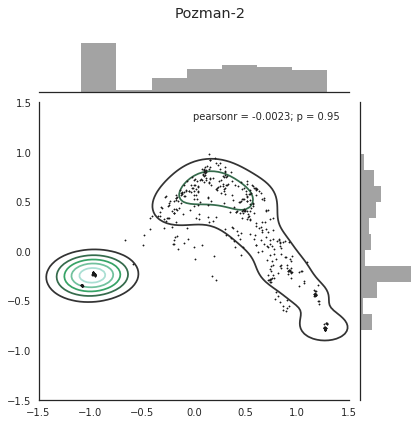

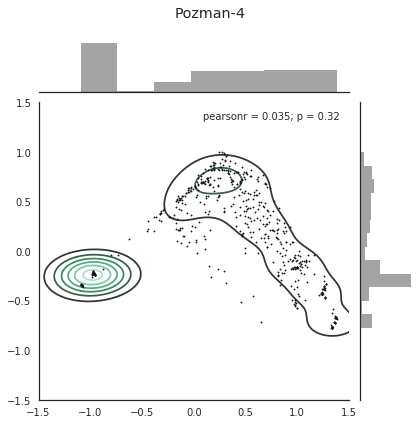

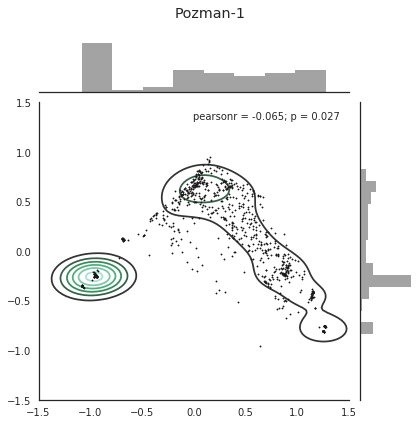

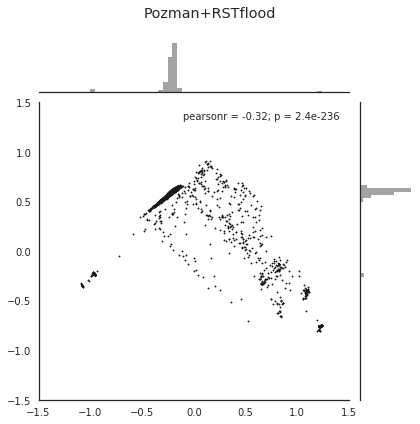

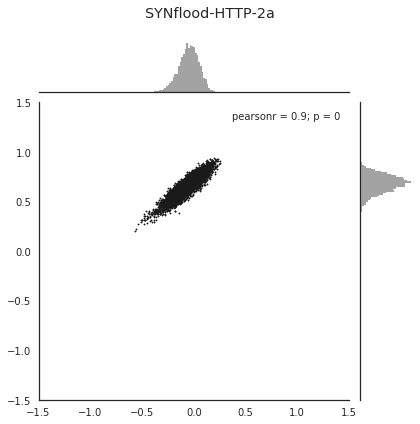

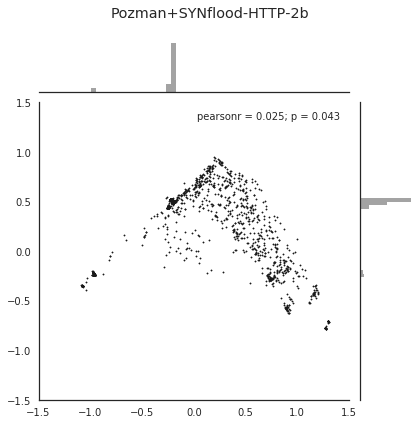

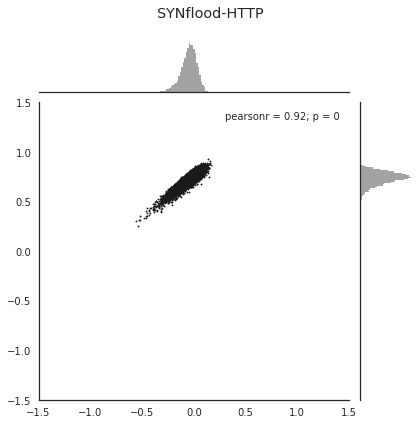

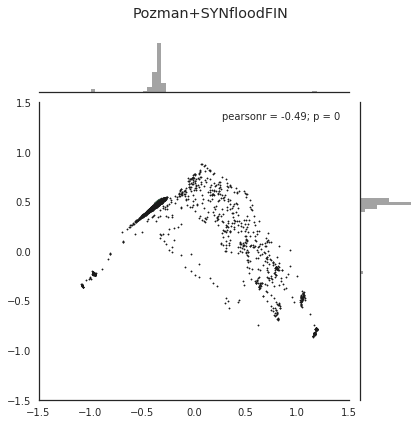

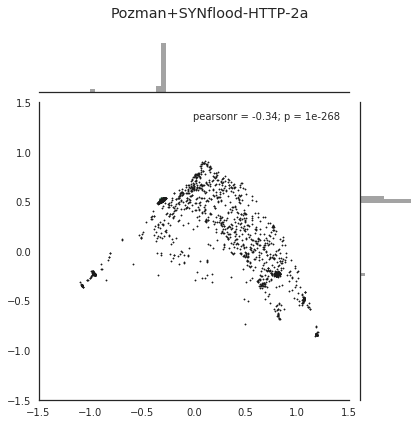

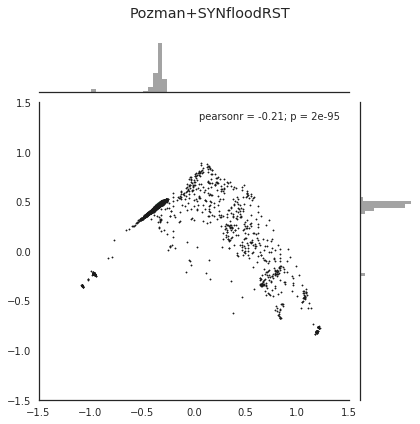

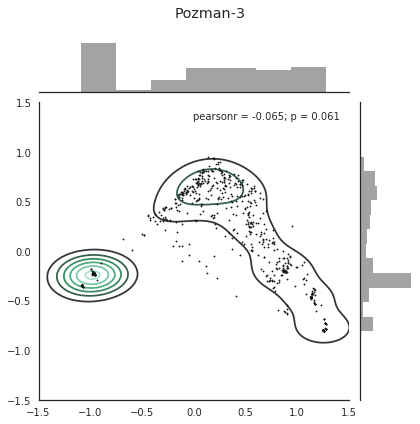

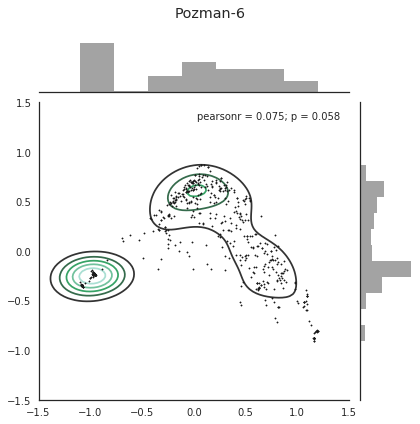

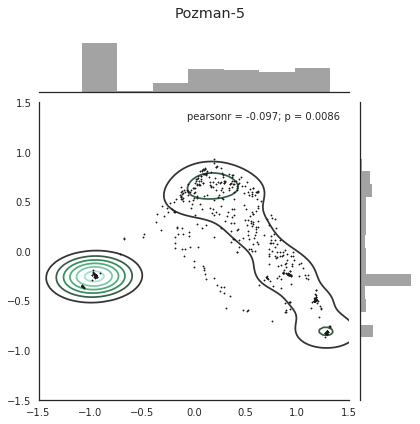

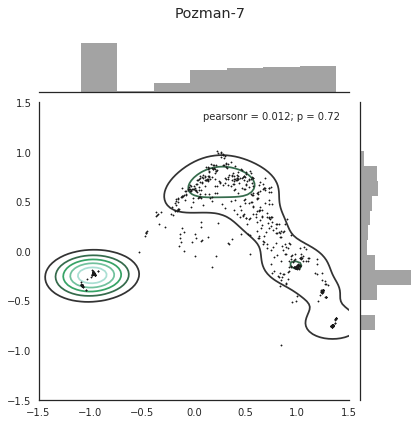

In [39]:
import seaborn as sns; sns.set(style="white", color_codes=True)

for name, data in above_threshold_data2.items():
    sampled_data = data[:10000]
    g = sns.jointplot(sampled_data[:,0], sampled_data[:, 1], color="k", s=2,
                     xlim=(-1.5,1.5), ylim=(-1.5,1.5)).plot_joint(sns.kdeplot, zorder=0, n_levels=6)
    plt.subplots_adjust(top=0.9)
    sns.plt.suptitle(name)

## Normal traffic density calculation
![title](Flow_density_anomalies_images/Density anomalities4.png)

In [40]:
SIZE = 20
MAX = 1.3

def seach_novelities2(data, name):
    sampled_data = data
    hist, xedges, yedges  = np.histogram2d(sampled_data[:,0],sampled_data[:,1],
                                           bins=np.linspace(-MAX, MAX, num=SIZE)) #,normed=True)
    from matplotlib.colors import LogNorm
    return hist

def get_mean_std_hists(above_threshold_data):
    normal_hists = []
    for name, data in above_threshold_data.items():   
        if not 'flood' in name:
            hist = seach_novelities2(data, name).T
            #print(name)
            #print(hist)
            normal_hists.append(hist)
        if name == 'Pozman-1':
            sampled_data = data
            hist = seach_novelities2(data, name).T
            print(name)
            #print(hist)
            plt.hist2d(sampled_data[:,0], sampled_data[:,1], bins=np.linspace(-MAX, MAX, num=SIZE), range=[(-2, 2),(-2, 2)])
            plt.colorbar()
            plt.title(name)
            plt.scatter(sampled_data[:,0], sampled_data[:, 1], color="green", s=2)
            plt.xlim(-2, 2)
            plt.ylim(-2, 2)
            plt.show()


    normal_hists = np.asarray(normal_hists)
    mean_hist = np.mean(normal_hists, axis=0)
    std_hist = np.std(normal_hists, axis=0)
    return mean_hist, std_hist

In [ ]:
mean_hist, std_hist = get_mean_std_hists(above_threshold_data2)

## Test density changes method

In [ ]:
def find_density_changes(data, name, mean_hist, std_hist):
    sampled_data = data[:10000] 
    print(name)
    hist = seach_novelities2(data, name).T

    print("Max desity is %f" % np.max(hist))
    #print(hist) #norm=LogNorm()
    plt.scatter(sampled_data[:,0], sampled_data[:, 1], color="green", s=2)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.hist2d(sampled_data[:,0], sampled_data[:,1], bins=np.linspace(-MAX, MAX, num=SIZE), range=[(-2, 2),(-2, 2)])
    plt.colorbar()
    plt.title(name)

    novelity_bins = []
    for x, y in np.ndindex((SIZE-1,SIZE-1)):
        value = hist[x][y]
        mean = mean_hist[x][y]
        std = std_hist[x][y]
        if mean + 4*std < value and value > 0.05*np.max(hist):
            bin_x_center = -MAX+(y+1)*2*MAX/SIZE
            bin_y_center = -MAX+(x+1)*2*MAX/SIZE
            bin_x_min, bin_x_max = -MAX+(y+0.5)*2*MAX/SIZE, -MAX+(y+1.5)*2*MAX/SIZE
            bin_y_min, bin_y_max = -MAX+(x+0.5)*2*MAX/SIZE, -MAX+(x+1.5)*2*MAX/SIZE
            
            novelity_bins.append((bin_x_min, bin_x_max, bin_y_min, bin_y_max))
            print("  Bin (%d,%d) with value: %.1f (normal is %.1f) [%.1f%%]" % (x, y, value, mean,100*value/mean))
            plt.scatter([bin_x_center], [bin_y_center], s=np.pi*5**2, c='red', marker='*')
    
    plt.show()
    print("Number of novelity bins is", len(novelity_bins))
    return novelity_bins

Pozman-1


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


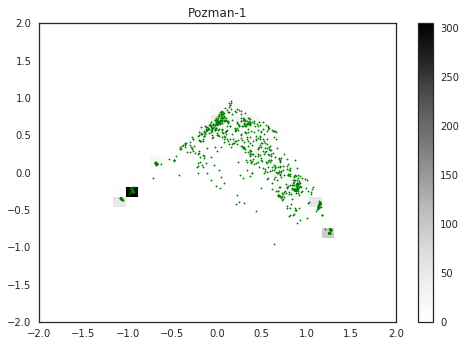

Pozman+SYNflood-HTTP
Max desity is 73380.000000
  Bin (12,6) with value: 41911.0 (normal is 3.0) [1397033.3%]
  Bin (12,7) with value: 43764.0 (normal is 8.0) [547050.0%]
  Bin (13,7) with value: 73380.0 (normal is 1.6) [4669636.4%]


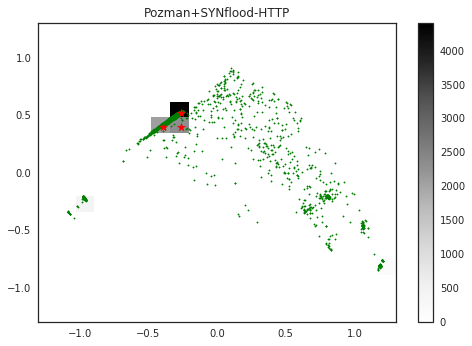

Number of novelity bins is 3
Pozman+RSTflood
Max desity is 80034.000000
  Bin (13,7) with value: 80034.0 (normal is 1.6) [5093072.7%]
  Bin (13,8) with value: 33449.0 (normal is 20.4) [163736.4%]
  Bin (14,8) with value: 45621.0 (normal is 2.7) [1680773.7%]


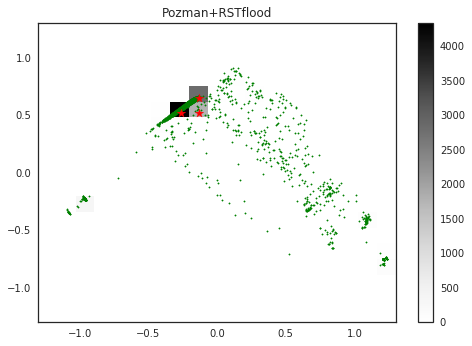

Number of novelity bins is 3
SYNflood-HTTP-2a
Max desity is 8266.000000
  Bin (12,7) with value: 467.0 (normal is 8.0) [5837.5%]
  Bin (13,7) with value: 1103.0 (normal is 1.6) [70190.9%]
  Bin (13,8) with value: 3754.0 (normal is 20.4) [18376.2%]
  Bin (14,8) with value: 3867.0 (normal is 2.7) [142468.4%]
  Bin (14,9) with value: 8266.0 (normal is 25.0) [33064.0%]
  Bin (15,9) with value: 2479.0 (normal is 4.4) [55977.4%]
  Bin (15,10) with value: 2044.0 (normal is 14.6) [14027.5%]


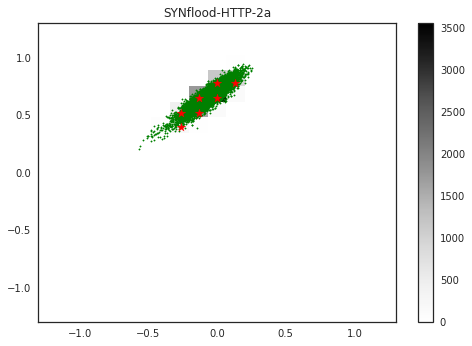

Number of novelity bins is 7
Pozman+SYNflood-HTTP-2b
Max desity is 3242.000000
  Bin (7,2) with value: 415.0 (normal is 208.1) [199.4%]
  Bin (12,7) with value: 566.0 (normal is 8.0) [7075.0%]
  Bin (13,7) with value: 1507.0 (normal is 1.6) [95900.0%]
  Bin (13,8) with value: 3242.0 (normal is 20.4) [15869.9%]


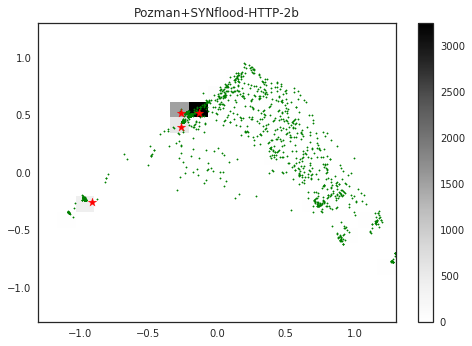

Number of novelity bins is 4
SYNflood-HTTP
Max desity is 47253.000000
  Bin (13,7) with value: 5551.0 (normal is 1.6) [353245.5%]
  Bin (13,8) with value: 5478.0 (normal is 20.4) [26815.4%]
  Bin (14,8) with value: 40777.0 (normal is 2.7) [1502310.5%]
  Bin (14,9) with value: 36032.0 (normal is 25.0) [144128.0%]
  Bin (15,9) with value: 47253.0 (normal is 4.4) [1067003.2%]
  Bin (15,10) with value: 6173.0 (normal is 14.6) [42363.7%]


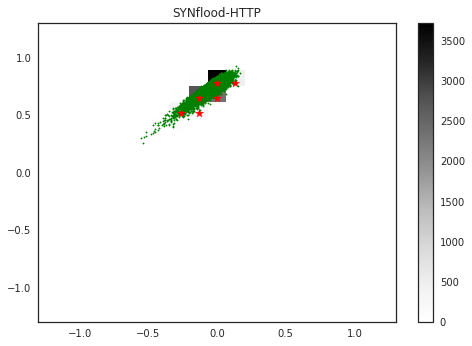

Number of novelity bins is 6
Pozman+SYNfloodFIN
Max desity is 73496.000000
  Bin (12,6) with value: 66896.0 (normal is 3.0) [2229866.7%]
  Bin (13,6) with value: 15249.0 (normal is 0.0) [inf%]
  Bin (13,7) with value: 73496.0 (normal is 1.6) [4677018.2%]


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:64: RuntimeWarning: divide by zero encountered in double_scalars


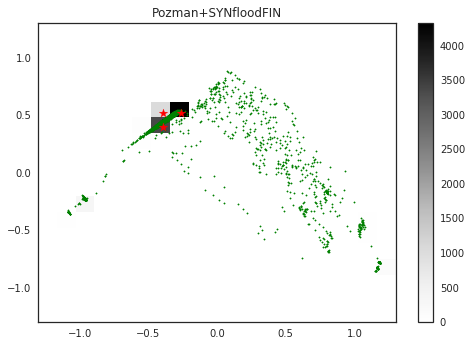

Number of novelity bins is 3
Pozman+SYNflood-HTTP-2a
Max desity is 20211.000000
  Bin (7,2) with value: 1382.0 (normal is 208.1) [664.0%]
  Bin (13,7) with value: 20211.0 (normal is 1.6) [1286154.5%]


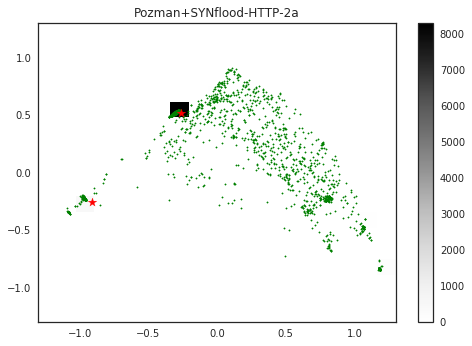

Number of novelity bins is 2
Pozman+SYNfloodRST
Max desity is 62243.000000
  Bin (7,2) with value: 3137.0 (normal is 208.1) [1507.1%]
  Bin (12,6) with value: 62243.0 (normal is 3.0) [2074766.7%]
  Bin (12,7) with value: 42993.0 (normal is 8.0) [537412.5%]
  Bin (13,7) with value: 54224.0 (normal is 1.6) [3450618.2%]


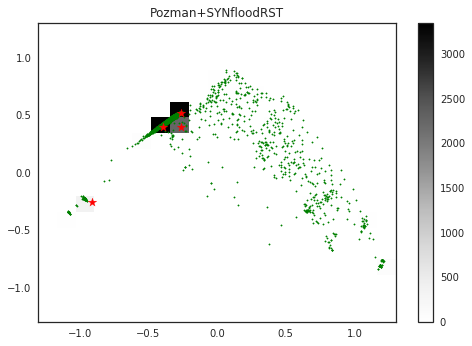

Number of novelity bins is 4


In [41]:
for name, data in above_threshold_data2.items():   
    if 'flood' in name:
        novelity_bins = find_density_changes(data, name, mean_hist, std_hist)

## Get final results for anomalities detection using density changes localization

![title](Flow_density_anomalies_images/Density anomalities5.png)

In [42]:
def detect_ddos(hdfs, datasets, traffic, features, autoencoder1, autoencoder2, mean_hist, std_hist, gen_graphs=False):
    start_time = time.time()
    tp_flows, tn_flows, fp_flows, fn_flows = [], [], [], []   
    
    print("Analysing traffic:", traffic)
    
    flows = list(ds.get_flows(hdfs, datasets[traffic]))
    _testdata, _features = ds.prepare_data(flows, features, flow_modification_f=modify_flow)
    _scoretest = autoencoder1.score(_testdata)
    
    _flows_above_threshold = [flow for flow, score in zip(flows, _scoretest) if score > threshold_error]
    
    flows_len, above_len = len(flows), len(_flows_above_threshold)
    print("First AE reduced flow count from %i to %i (%i%%)" % (flows_len, above_len, 100.0*(flows_len-above_len)/flows_len))
    
    traindata2, _features = ds.prepare_data(_flows_above_threshold, features, flow_modification_f=modify_flow)
    _scoretest2 = autoencoder2.score(traindata2)
    
    flows_above_threshold = [flow for flow, score in zip(flows, _scoretest2) if score > threshold_error2]
    
    above2_len = len(flows_above_threshold)
    print("Second AE reduced flow count from %i to %i (%i%%)" % (above_len, above2_len, 100.0*(above_len-above2_len)/above_len))
    
    flow_categories, ddos_category, pca_data = cluster2D_and_analyze_flows(flows_above_threshold, features, gen_graphs=True)
    
    plt.show()
    
    novelity_bins = find_density_changes(pca_data, traffic, mean_hist, std_hist)
    
    is_ddos_density = []
    for flow_pca in pca_data:
        is_ddos = False
        for bin_x_min, bin_x_max, bin_y_min, bin_y_max in novelity_bins:
            if bin_x_min <= flow_pca[0] <= bin_x_max and bin_y_min <= flow_pca[1] <= bin_y_max:
                is_ddos = True
                break
        is_ddos_density.append(is_ddos) 
    
    print("--- Execution time was %s seconds ---" % (time.time() - start_time))
    
    if len(flows) != len(_testdata):
        print('Different number of element is flows (%i) and _testdata (%i) structures' % (len(flows), len(_testdata)))
    
    ddos = [skip_ddos(flow) for flow in flows]
    ddos_above = [skip_ddos(flow) for flow in _flows_above_threshold]
    ddos_above2 = [skip_ddos(flow) for flow in flows_above_threshold]
    #print(ddos_above2)
    
    
    for index in range(len(flows_above_threshold)):
        if is_ddos_density[index]:
            if ddos_above2[index]:
                tp_flows.append(flows_above_threshold[index])
            else:
                fp_flows.append(flows_above_threshold[index])
        else:
            if ddos_above2[index]:
                fn_flows.append(flows_above_threshold[index])
            else:
                tn_flows.append(flows_above_threshold[index])
                
    for index, score in enumerate(_scoretest2):
        if score <= threshold_error2:
            if ddos_above[index]:
                fn_flows.append(_flows_above_threshold[index])
            else:
                tn_flows.append(_flows_above_threshold[index])
                
    for index, score in enumerate(_scoretest):
        if score <= threshold_error:
            if ddos[index]:
                fn_flows.append(flows[index])
            else:
                tn_flows.append(flows[index])
           
    false_positive = len(fp_flows)  # scored as DDoS and is not DDoS
    false_negative = len(fn_flows)  # scored as non-DDoS and is DDoS
    true_positive = len(tp_flows)   # scored as DDoS and is DDoS
    true_negative = len(tn_flows)  # scored as non-DDoS and is not DDoS
    
    ddos_cnt = true_positive + false_negative
    no_ddos_cnt = true_negative + false_positive
    
    # prevent from zero divition exception
    if ddos_cnt == 0: ddos_cnt = 1
    if no_ddos_cnt == 0: no_ddos_cnt = 1
    
    if gen_graphs:
        plt.figure(figsize=(10,5))
        plt.plot(_scoretest2, color='lightblue')
        plt.plot(ds.movingaverage(_scoretest2, window=10), color='darkblue')
        plt.axhline(threshold_error2, color='brown', label='upper train error')
        plt.title("Test error distribution in %s dataset" % traffic)
        plt.xlabel('flow index')
        plt.ylabel('error')
        plt.show()
        
    fpr = 100.0*false_positive/no_ddos_cnt
    fnr = 100.0*false_negative/ddos_cnt
    sensitivity = 100.0*true_positive/ddos_cnt
    specificity = 100.0*true_negative/no_ddos_cnt
    gmean = math.sqrt(specificity * sensitivity)
    
    print("  Flows scored as DDoS and is DDoS: %i (Sensivity: %.2f %%)" % (true_positive, sensitivity))
    print("  Flows scored as non-DDoS and is DDoS: %i (FNR: %.2f %%)" % (false_negative, fnr))
    print("  Flows scored as non-DDoS and is not DDoS: %i (Specifity: %.2f %%)" % (true_negative, specificity))
    print("  Flows scored as DDoS and is not DDoS: %i (FPR: %.2f %%)" % (false_positive, fpr))
    print()
    
    return {'FPR': fpr, 'FNR': fnr,
            'sensitivity (TPR)': sensitivity, 'specificity (TNR)': specificity, 'gmean': gmean,
            'time': time.time()-start_time}

Analysing traffic: Pozman+SYNflood-HTTP
Skipped flows: 0 from 200601 (0.00%)
First AE reduced flow count from 200601 to 178649 (10%)
Second AE reduced flow count from 178649 to 172954 (3%)
Number of flow clustered: 172954
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


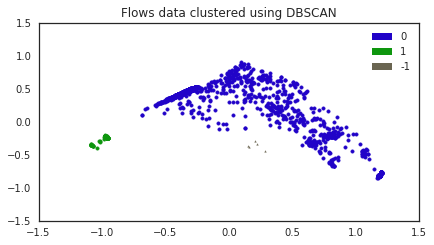

Category id #0 contains 9572 flows
                max_packet_length: 65.7-67.2 (92%)
                 min_payload_byte: 1 (93%)
                    total_datalen: 31.0-23310.4 (99%)
                        tcp_flags: 2 (92%)
                     dst_port_cnt: 1 (98%)
               mean_packet_length: 65.7-67.1 (92%)
                         pkts_cnt: 1.0-17.9 (96%)
                     traffic_type: 192 (92%)
                     src_port_cnt: 1 (98%)
                min_packet_length: 65.7-67.1 (92%)
            std_dev_packet_length: 0.0-0.7 (94%)
                         syn_prop: 1.0 (92%)
                      ip_protocol: 6 (98%)
                        bytes_cnt: 88.0-24345.8 (98%)
Category id #1 contains 423 flows
                 min_payload_byte: 0 (100%)
             std_dev_payload_byte: 0.0 (100%)
                        tcp_flags: 16 (89%)
                mean_payload_byte: 0.0 (100%)
                       src_ip_cnt: 1 (77%)
                     dst_port_cnt: 1 (97%)


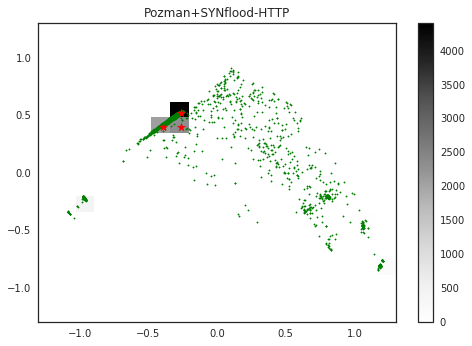

Number of novelity bins is 3
--- Execution time was 107.33538126945496 seconds ---
  Flows scored as DDoS and is DDoS: 125561 (Sensivity: 76.05 %)
  Flows scored as non-DDoS and is DDoS: 39547 (FNR: 23.95 %)
  Flows scored as non-DDoS and is not DDoS: 34847 (Specifity: 98.18 %)
  Flows scored as DDoS and is not DDoS: 646 (FPR: 1.82 %)

Analysing traffic: Pozman-2
Skipped flows: 0 from 30943 (0.00%)
First AE reduced flow count from 30943 to 7794 (74%)
Second AE reduced flow count from 7794 to 624 (91%)
Number of flow clustered: 624
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


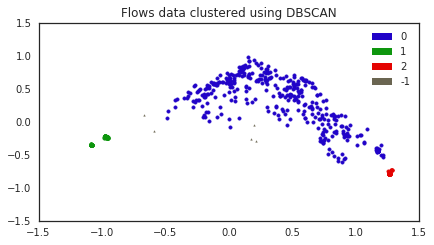

Category id #0 contains 384 flows
                         pkts_cnt: 1.0-29.5 (70%)
                    total_datalen: 1.0-39341.4 (90%)
                     traffic_type: 0 (91%)
                     src_port_cnt: 1.0-1.1 (76%)
                       src_ip_cnt: 1 (77%)
                     dst_port_cnt: 1 (76%)
                        bytes_cnt: 60.0-41053.9 (88%)
Category id #1 contains 188 flows
             std_dev_payload_byte: 0.0 (100%)
                mean_payload_byte: 0.0 (100%)
                       src_ip_cnt: 1 (87%)
                     dst_port_cnt: 1 (93%)
                 max_payload_byte: 0 (100%)
                 min_payload_byte: 0 (100%)
                     traffic_type: 0 (94%)
                     src_port_cnt: 1 (79%)
            std_dev_packet_length: 0.00-0.01 (75%)
                    total_datalen: 0 (99%)
        byte_distribution_entropy: 0.0 (100%)
                      ip_protocol: 6 (100%)
Category id #2 contains 47 flows
                 min_payload

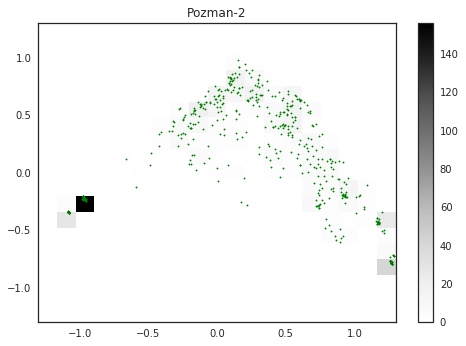

Number of novelity bins is 0
--- Execution time was 7.19564962387085 seconds ---
  Flows scored as DDoS and is DDoS: 0 (Sensivity: 0.00 %)
  Flows scored as non-DDoS and is DDoS: 5714 (FNR: 100.00 %)
  Flows scored as non-DDoS and is not DDoS: 25229 (Specifity: 100.00 %)
  Flows scored as DDoS and is not DDoS: 0 (FPR: 0.00 %)

Analysing traffic: Pozman-4
Skipped flows: 0 from 31401 (0.00%)
First AE reduced flow count from 31401 to 8086 (74%)
Second AE reduced flow count from 8086 to 782 (90%)
Number of flow clustered: 782
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


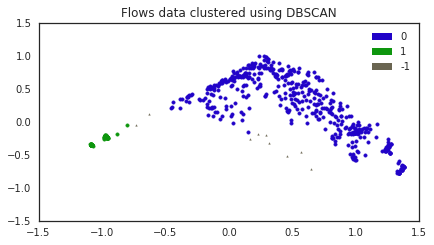

Category id #0 contains 514 flows
                         pkts_cnt: 1.0-29.5 (72%)
                    total_datalen: 17.0-39379.6 (91%)
                     traffic_type: 0 (96%)
                     src_port_cnt: 1.0-1.1 (79%)
                       src_ip_cnt: 1.0-1.0 (81%)
                     dst_port_cnt: 1.0-1.7 (90%)
                        bytes_cnt: 66.0-41083.6 (89%)
Category id #1 contains 259 flows
             std_dev_payload_byte: 0.0 (99%)
                        tcp_flags: 16 (79%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (82%)
                     dst_port_cnt: 1 (94%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (99%)
                 min_payload_byte: 0 (100%)
                     traffic_type: 0 (92%)
                     src_port_cnt: 1 (76%)
            std_dev_packet_length: 0.00-0.01 (82%)
                    total_datalen: 0 (98%)
                      ip_protocol: 6 (99%)
Pozman-4


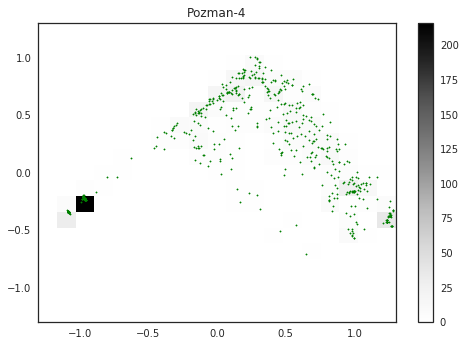

Number of novelity bins is 0
--- Execution time was 7.552284240722656 seconds ---
  Flows scored as DDoS and is DDoS: 0 (Sensivity: 0.00 %)
  Flows scored as non-DDoS and is DDoS: 5930 (FNR: 100.00 %)
  Flows scored as non-DDoS and is not DDoS: 25471 (Specifity: 100.00 %)
  Flows scored as DDoS and is not DDoS: 0 (FPR: 0.00 %)

Analysing traffic: Pozman-1
Skipped flows: 0 from 31857 (0.00%)
First AE reduced flow count from 31857 to 7863 (75%)
Second AE reduced flow count from 7863 to 1154 (85%)
Number of flow clustered: 1154
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


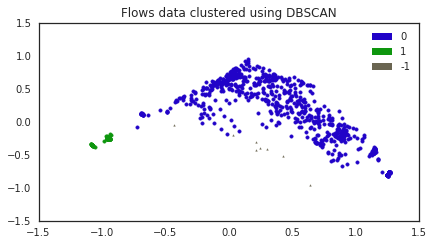

Category id #0 contains 784 flows
                         pkts_cnt: 1.0-22.3 (68%)
                    total_datalen: 1.0-30495.6 (90%)
                     traffic_type: 0 (94%)
                     src_port_cnt: 1.0-1.1 (81%)
                       src_ip_cnt: 1 (82%)
                     dst_port_cnt: 1.0-2.0 (92%)
                        bytes_cnt: 60.0-31789.7 (89%)
Category id #1 contains 362 flows
                 min_payload_byte: 0 (99%)
             std_dev_payload_byte: 0.0 (100%)
                        tcp_flags: 16 (77%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (85%)
                     dst_port_cnt: 1 (97%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (100%)
                         pkts_cnt: 1.0-44.2 (80%)
                     traffic_type: 0 (93%)
                     src_port_cnt: 1 (75%)
            std_dev_packet_length: 0.0-0.0 (80%)
                    total_datalen: 0 (97%)
          

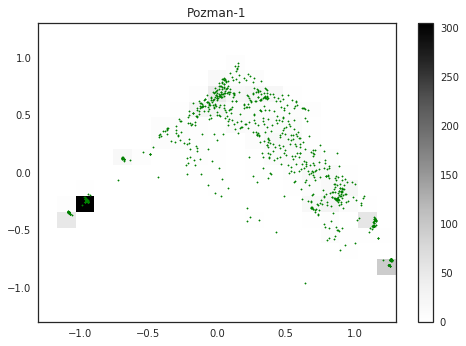

Number of novelity bins is 0
--- Execution time was 10.49667501449585 seconds ---
  Flows scored as DDoS and is DDoS: 0 (Sensivity: 0.00 %)
  Flows scored as non-DDoS and is DDoS: 5715 (FNR: 100.00 %)
  Flows scored as non-DDoS and is not DDoS: 26142 (Specifity: 100.00 %)
  Flows scored as DDoS and is not DDoS: 0 (FPR: 0.00 %)

Analysing traffic: Pozman+RSTflood
Skipped flows: 0 from 196855 (0.00%)
First AE reduced flow count from 196855 to 178312 (9%)
Second AE reduced flow count from 178312 to 173224 (2%)
Number of flow clustered: 173224
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


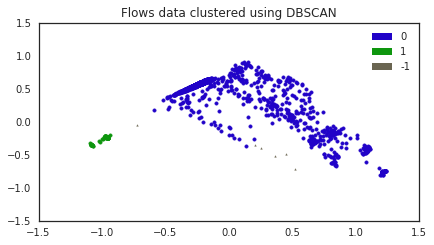

Category id #0 contains 9664 flows
                max_packet_length: 66.0-67.4 (93%)
                 min_payload_byte: 0.7-0.9 (95%)
                         rst_prop: 1.0 (93%)
                        tcp_flags: 4 (93%)
               mean_packet_length: 65.2-66.7 (93%)
                         pkts_cnt: 1.0-12.2 (97%)
                     traffic_type: 192 (93%)
                        bytes_cnt: 66.0-16686.9 (98%)
            std_dev_packet_length: 0.0-0.7 (95%)
                    total_datalen: 20.0-15993.9 (98%)
                      ip_protocol: 6 (97%)
                min_packet_length: 65.7-67.2 (93%)
Category id #1 contains 330 flows
             std_dev_payload_byte: 0.0 (100%)
                        tcp_flags: 16 (90%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (81%)
                     dst_port_cnt: 1 (96%)
                 max_payload_byte: 0 (99%)
                 min_payload_byte: 0 (99%)
                     traffic_type: 0 (9

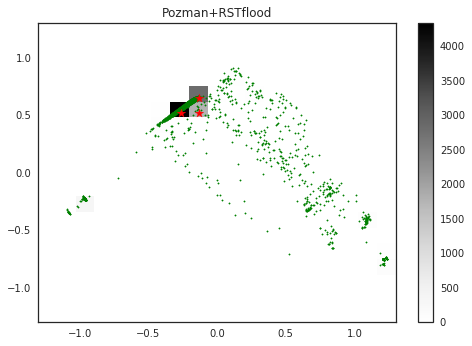

Number of novelity bins is 3
--- Execution time was 105.08959722518921 seconds ---
  Flows scored as DDoS and is DDoS: 103094 (Sensivity: 62.07 %)
  Flows scored as non-DDoS and is DDoS: 62991 (FNR: 37.93 %)
  Flows scored as non-DDoS and is not DDoS: 29995 (Specifity: 97.48 %)
  Flows scored as DDoS and is not DDoS: 775 (FPR: 2.52 %)

Analysing traffic: SYNflood-HTTP-2a
Skipped flows: 0 from 24576 (0.00%)


/home/jovyan/work/dataset_utils2.py:342: RuntimeWarning: invalid value encountered in true_divide
  scalled = high - (((high - low) * (maxs - rawpoints)) / rng)  # throws warnings divide by zero


First AE reduced flow count from 24576 to 23170 (5%)
Second AE reduced flow count from 23170 to 23136 (0%)
Number of flow clustered: 23136
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


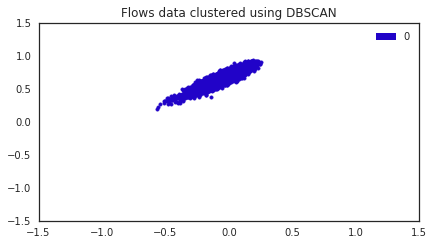

Category id #0 contains 10000 flows
                max_packet_length: 68 (100%)
                 min_payload_byte: 1 (99%)
                     traffic_type: 192 (100%)
                     src_port_cnt: 1 (100%)
                        tcp_flags: 2 (100%)
                min_packet_length: 68 (100%)
            std_dev_packet_length: 0.0 (100%)
                         syn_prop: 1.0 (100%)
                     dst_port_cnt: 1 (100%)
                      ip_protocol: 6 (100%)
               mean_packet_length: 68.0 (100%)
SYNflood-HTTP-2a
Max desity is 8266.000000
  Bin (12,7) with value: 467.0 (normal is 8.0) [5837.5%]
  Bin (13,7) with value: 1103.0 (normal is 1.6) [70190.9%]
  Bin (13,8) with value: 3754.0 (normal is 20.4) [18376.2%]
  Bin (14,8) with value: 3867.0 (normal is 2.7) [142468.4%]
  Bin (14,9) with value: 8266.0 (normal is 25.0) [33064.0%]
  Bin (15,9) with value: 2479.0 (normal is 4.4) [55977.4%]
  Bin (15,10) with value: 2044.0 (normal is 14.6) [14027.5%]


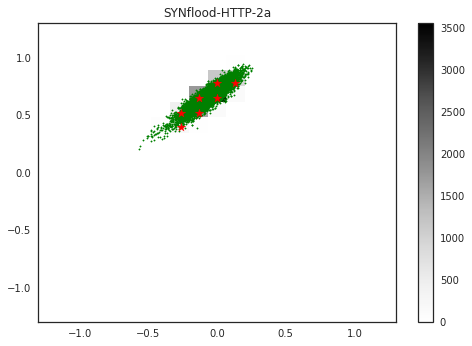

Number of novelity bins is 7
--- Execution time was 69.15972542762756 seconds ---
  Flows scored as DDoS and is DDoS: 21848 (Sensivity: 88.90 %)
  Flows scored as non-DDoS and is DDoS: 2728 (FNR: 11.10 %)
  Flows scored as non-DDoS and is not DDoS: 0 (Specifity: 0.00 %)
  Flows scored as DDoS and is not DDoS: 0 (FPR: 0.00 %)

Analysing traffic: Pozman+SYNflood-HTTP-2b
Skipped flows: 0 from 37144 (0.00%)
First AE reduced flow count from 37144 to 13622 (63%)
Second AE reduced flow count from 13622 to 6577 (51%)
Number of flow clustered: 6577
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


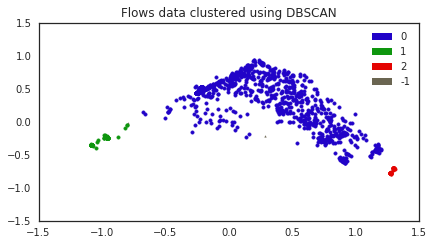

Category id #0 contains 6081 flows
                max_packet_length: 65.8-67.2 (86%)
                        tcp_flags: 2 (86%)
                     dst_port_cnt: 1 (96%)
               mean_packet_length: 65.8-67.2 (87%)
                 min_payload_byte: 0.7-0.9 (90%)
                     traffic_type: 192 (86%)
                        bytes_cnt: 90.0-27128.7 (96%)
                min_packet_length: 65.8-67.2 (86%)
            std_dev_packet_length: 0.0-0.7 (89%)
                    total_datalen: 44.0-26238.1 (96%)
                      ip_protocol: 6 (94%)
                     src_port_cnt: 1.0-1.2 (96%)
Category id #1 contains 461 flows
                 min_payload_byte: 0 (100%)
             std_dev_payload_byte: 0.0 (99%)
                        tcp_flags: 16 (84%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (86%)
                     dst_port_cnt: 1 (97%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (99

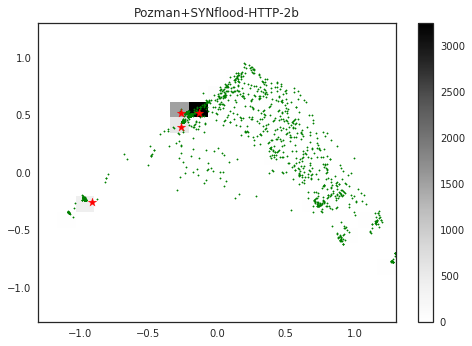

Number of novelity bins is 4
--- Execution time was 38.89244771003723 seconds ---
  Flows scored as DDoS and is DDoS: 3 (Sensivity: 0.05 %)
  Flows scored as non-DDoS and is DDoS: 5796 (FNR: 99.95 %)
  Flows scored as non-DDoS and is not DDoS: 25633 (Specifity: 81.78 %)
  Flows scored as DDoS and is not DDoS: 5712 (FPR: 18.22 %)

Analysing traffic: SYNflood-HTTP
Skipped flows: 0 from 172031 (0.00%)


/home/jovyan/work/dataset_utils2.py:342: RuntimeWarning: invalid value encountered in true_divide
  scalled = high - (((high - low) * (maxs - rawpoints)) / rng)  # throws warnings divide by zero


First AE reduced flow count from 172031 to 143859 (16%)
Second AE reduced flow count from 143859 to 143729 (0%)
Number of flow clustered: 143729
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


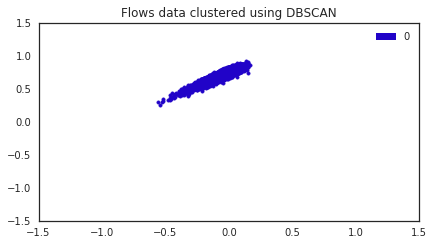

Category id #0 contains 10000 flows
                max_packet_length: 68 (100%)
                 min_payload_byte: 1 (99%)
                     traffic_type: 192 (100%)
                     src_port_cnt: 1 (100%)
                        tcp_flags: 2 (100%)
                min_packet_length: 68 (100%)
            std_dev_packet_length: 0.0 (100%)
                         syn_prop: 1.0 (100%)
                     dst_port_cnt: 1 (100%)
                      ip_protocol: 6 (100%)
               mean_packet_length: 68.0 (100%)
SYNflood-HTTP
Max desity is 47253.000000
  Bin (13,7) with value: 5551.0 (normal is 1.6) [353245.5%]
  Bin (13,8) with value: 5478.0 (normal is 20.4) [26815.4%]
  Bin (14,8) with value: 40777.0 (normal is 2.7) [1502310.5%]
  Bin (14,9) with value: 36032.0 (normal is 25.0) [144128.0%]
  Bin (15,9) with value: 47253.0 (normal is 4.4) [1067003.2%]
  Bin (15,10) with value: 6173.0 (normal is 14.6) [42363.7%]


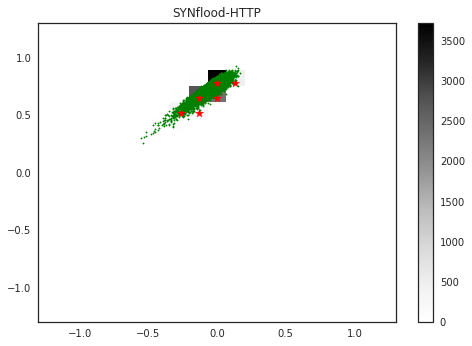

Number of novelity bins is 6
--- Execution time was 102.66166853904724 seconds ---
  Flows scored as DDoS and is DDoS: 129066 (Sensivity: 75.02 %)
  Flows scored as non-DDoS and is DDoS: 42965 (FNR: 24.98 %)
  Flows scored as non-DDoS and is not DDoS: 0 (Specifity: 0.00 %)
  Flows scored as DDoS and is not DDoS: 0 (FPR: 0.00 %)

Analysing traffic: Pozman+SYNfloodFIN
Skipped flows: 0 from 200133 (0.00%)
First AE reduced flow count from 200133 to 178533 (10%)
Second AE reduced flow count from 178533 to 172926 (3%)
Number of flow clustered: 172926
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


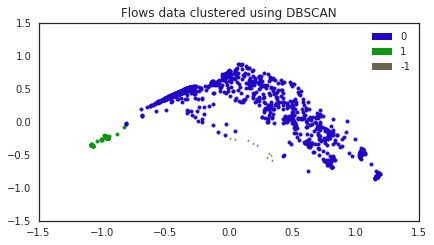

Category id #0 contains 9648 flows
                max_packet_length: 66.0-67.4 (91%)
                    total_datalen: 20.0-3986.1 (94%)
                        tcp_flags: 3 (91%)
                         fin_prop: 1.0 (91%)
               mean_packet_length: 65.9-67.3 (91%)
                 min_payload_byte: 0.7-0.9 (93%)
                     traffic_type: 192 (91%)
                        bytes_cnt: 82.0-4175.1 (94%)
            std_dev_packet_length: 0.0-0.7 (94%)
                         syn_prop: 1.0 (91%)
                      ip_protocol: 6 (97%)
                min_packet_length: 65.7-67.1 (91%)
Category id #1 contains 343 flows
                 min_payload_byte: 0 (99%)
             std_dev_payload_byte: 0.0 (99%)
                        tcp_flags: 16 (85%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (79%)
                     dst_port_cnt: 1 (97%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (99%)
  

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:64: RuntimeWarning: divide by zero encountered in double_scalars


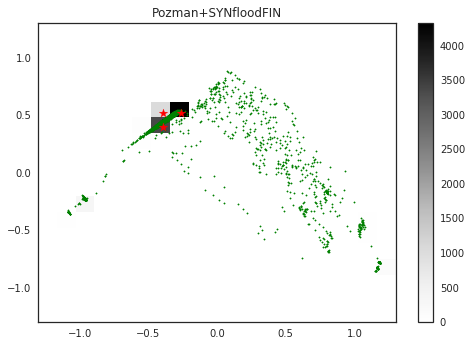

Number of novelity bins is 3
--- Execution time was 105.32946348190308 seconds ---
  Flows scored as DDoS and is DDoS: 154804 (Sensivity: 94.13 %)
  Flows scored as non-DDoS and is DDoS: 9653 (FNR: 5.87 %)
  Flows scored as non-DDoS and is not DDoS: 35153 (Specifity: 98.53 %)
  Flows scored as DDoS and is not DDoS: 523 (FPR: 1.47 %)

Analysing traffic: Pozman+SYNflood-HTTP-2a
Skipped flows: 0 from 59626 (0.00%)
First AE reduced flow count from 59626 to 32604 (45%)
Second AE reduced flow count from 32604 to 25301 (22%)
Number of flow clustered: 25301
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


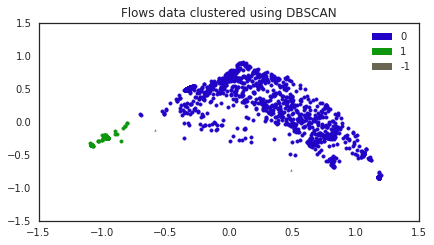

Category id #0 contains 9481 flows
                max_packet_length: 65.9-67.3 (87%)
                        tcp_flags: 2 (87%)
                     dst_port_cnt: 1 (97%)
               mean_packet_length: 66.5-67.9 (87%)
                 min_payload_byte: 0.5-0.8 (88%)
                     traffic_type: 192 (87%)
                        bytes_cnt: 71.0-4303.3 (92%)
                min_packet_length: 65.8-67.2 (87%)
            std_dev_packet_length: 0.0-0.8 (90%)
                    total_datalen: 24.0-4125.2 (93%)
                      ip_protocol: 6 (95%)
                     src_port_cnt: 1 (97%)
Category id #1 contains 517 flows
                 min_payload_byte: 0 (99%)
             std_dev_payload_byte: 0.0 (98%)
                        tcp_flags: 16 (86%)
                mean_payload_byte: 0.0 (98%)
                       src_ip_cnt: 1 (78%)
                     dst_port_cnt: 1 (95%)
                 max_payload_byte: 0 (98%)
        byte_distribution_entropy: 0.0 (98%)
      

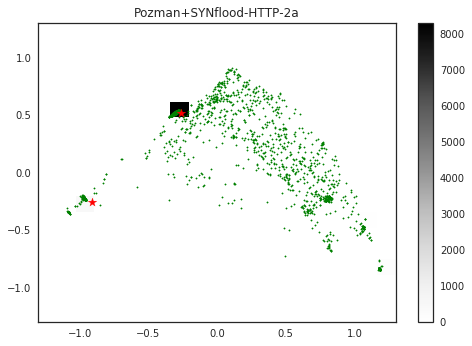

Number of novelity bins is 2
--- Execution time was 74.12064409255981 seconds ---
  Flows scored as DDoS and is DDoS: 19747 (Sensivity: 75.62 %)
  Flows scored as non-DDoS and is DDoS: 6365 (FNR: 24.38 %)
  Flows scored as non-DDoS and is not DDoS: 32161 (Specifity: 95.96 %)
  Flows scored as DDoS and is not DDoS: 1353 (FPR: 4.04 %)

Analysing traffic: Pozman+SYNfloodRST
Skipped flows: 0 from 201178 (0.00%)
First AE reduced flow count from 201178 to 180033 (10%)
Second AE reduced flow count from 180033 to 174822 (2%)
Number of flow clustered: 174822
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


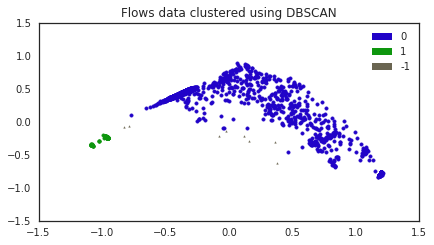

Category id #0 contains 9606 flows
                max_packet_length: 66.0-67.4 (93%)
                 min_payload_byte: 0.5-0.8 (94%)
                    total_datalen: 20.0-13214.7 (98%)
                         rst_prop: 1.0 (93%)
                        tcp_flags: 6 (93%)
               mean_packet_length: 66.1-67.6 (93%)
                         pkts_cnt: 1.0-10.2 (95%)
                     traffic_type: 192 (93%)
                        bytes_cnt: 77.0-13806.1 (97%)
            std_dev_packet_length: 0.0-0.6 (94%)
                         syn_prop: 1.0 (93%)
                      ip_protocol: 6 (96%)
                min_packet_length: 65.7-67.1 (93%)
Category id #1 contains 386 flows
             std_dev_payload_byte: 0.0 (100%)
                        tcp_flags: 16 (87%)
                mean_payload_byte: 0.0 (100%)
                       src_ip_cnt: 1 (74%)
                     dst_port_cnt: 1 (97%)
                 max_payload_byte: 0 (100%)
                 min_payload_byte: 

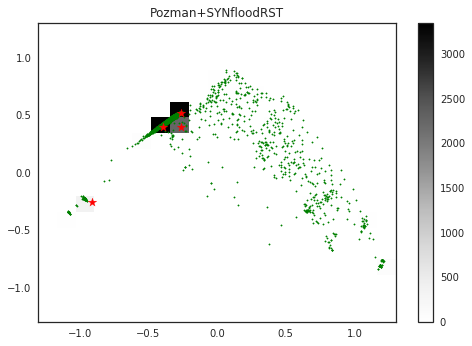

Number of novelity bins is 4
--- Execution time was 108.52495455741882 seconds ---
  Flows scored as DDoS and is DDoS: 113308 (Sensivity: 68.23 %)
  Flows scored as non-DDoS and is DDoS: 52753 (FNR: 31.77 %)
  Flows scored as non-DDoS and is not DDoS: 31786 (Specifity: 90.51 %)
  Flows scored as DDoS and is not DDoS: 3331 (FPR: 9.49 %)

Analysing traffic: Pozman-3
Skipped flows: 0 from 31137 (0.00%)
First AE reduced flow count from 31137 to 7737 (75%)
Second AE reduced flow count from 7737 to 831 (89%)
Number of flow clustered: 831
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


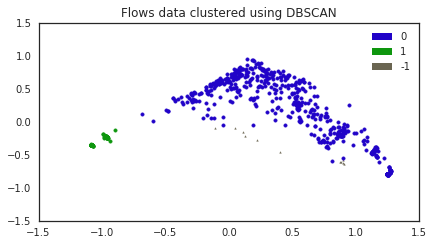

Category id #0 contains 566 flows
                     dst_port_cnt: 1.0-1.0 (79%)
                       src_ip_cnt: 1 (82%)
                     traffic_type: 0 (94%)
                     src_port_cnt: 1.0-1.0 (81%)
Category id #1 contains 254 flows
             std_dev_payload_byte: 0.0 (99%)
                        tcp_flags: 16 (76%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (85%)
                     dst_port_cnt: 1 (95%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (99%)
                 min_payload_byte: 0 (100%)
                     traffic_type: 0 (92%)
                     src_port_cnt: 1 (79%)
            std_dev_packet_length: 0.0-0.0 (81%)
                    total_datalen: 0 (97%)
                      ip_protocol: 6 (99%)
Pozman-3
Max desity is 210.000000


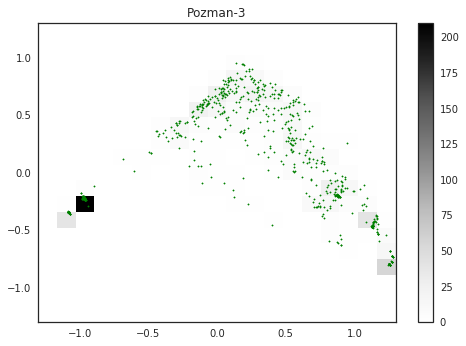

Number of novelity bins is 0
--- Execution time was 7.843968868255615 seconds ---
  Flows scored as DDoS and is DDoS: 0 (Sensivity: 0.00 %)
  Flows scored as non-DDoS and is DDoS: 5665 (FNR: 100.00 %)
  Flows scored as non-DDoS and is not DDoS: 25472 (Specifity: 100.00 %)
  Flows scored as DDoS and is not DDoS: 0 (FPR: 0.00 %)

Analysing traffic: Pozman-6
Skipped flows: 0 from 30671 (0.00%)
First AE reduced flow count from 30671 to 8032 (73%)
Second AE reduced flow count from 8032 to 634 (92%)
Number of flow clustered: 634
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


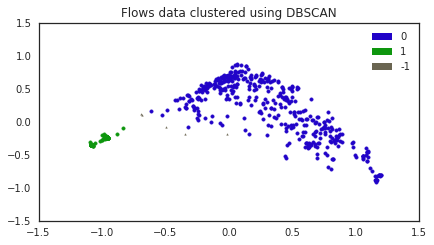

Category id #0 contains 429 flows
                         pkts_cnt: 1.0-24.2 (67%)
                    total_datalen: 3.0-29963.8 (87%)
                     traffic_type: 0 (90%)
                     src_port_cnt: 1.0-2.5 (91%)
                       src_ip_cnt: 1 (79%)
                     dst_port_cnt: 1 (77%)
                        bytes_cnt: 62.0-31559.7 (85%)
Category id #1 contains 200 flows
                 min_payload_byte: 0 (100%)
             std_dev_payload_byte: 0.0 (99%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (87%)
                     dst_port_cnt: 1 (94%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (99%)
                         pkts_cnt: 1.0-6.2 (51%)
                     traffic_type: 0 (94%)
                     src_port_cnt: 1 (75%)
            std_dev_packet_length: 0.0-0.0 (77%)
                    total_datalen: 0 (96%)
                      ip_protocol: 6 (98%)
                   

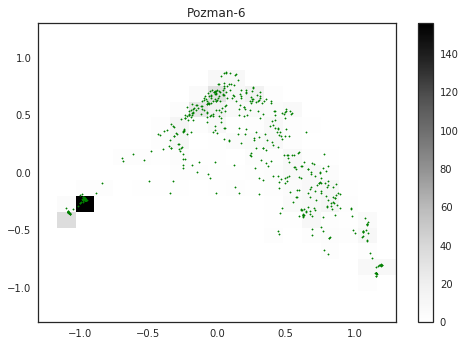

Number of novelity bins is 0
--- Execution time was 7.05500054359436 seconds ---
  Flows scored as DDoS and is DDoS: 0 (Sensivity: 0.00 %)
  Flows scored as non-DDoS and is DDoS: 5851 (FNR: 100.00 %)
  Flows scored as non-DDoS and is not DDoS: 24820 (Specifity: 100.00 %)
  Flows scored as DDoS and is not DDoS: 0 (FPR: 0.00 %)

Analysing traffic: Pozman-5
Skipped flows: 0 from 30911 (0.00%)
First AE reduced flow count from 30911 to 7959 (74%)
Second AE reduced flow count from 7959 to 729 (90%)
Number of flow clustered: 729
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


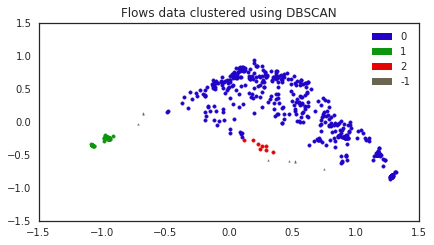

Category id #0 contains 474 flows
                         pkts_cnt: 1.0-21.5 (72%)
                    total_datalen: 1.0-29427.2 (92%)
                     traffic_type: 0 (95%)
                     src_port_cnt: 1 (82%)
                       src_ip_cnt: 1 (83%)
                     dst_port_cnt: 1 (80%)
                        bytes_cnt: 60.0-30678.0 (91%)
Category id #1 contains 239 flows
             std_dev_payload_byte: 0.0 (100%)
                        tcp_flags: 16 (76%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (86%)
                     dst_port_cnt: 1 (93%)
                 max_payload_byte: 0 (99%)
        byte_distribution_entropy: 0.0 (100%)
                 min_payload_byte: 0 (99%)
                     traffic_type: 0 (94%)
                     src_port_cnt: 1 (77%)
            std_dev_packet_length: 0.00-0.01 (84%)
                    total_datalen: 0 (98%)
                      ip_protocol: 6 (99%)
Category id #2 contains 8 f

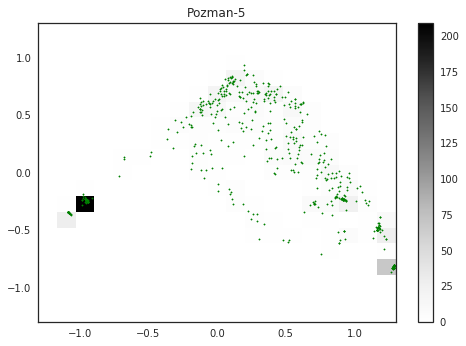

Number of novelity bins is 0
--- Execution time was 8.872827768325806 seconds ---
  Flows scored as DDoS and is DDoS: 0 (Sensivity: 0.00 %)
  Flows scored as non-DDoS and is DDoS: 5886 (FNR: 100.00 %)
  Flows scored as non-DDoS and is not DDoS: 25025 (Specifity: 100.00 %)
  Flows scored as DDoS and is not DDoS: 0 (FPR: 0.00 %)

Analysing traffic: Pozman-7
Skipped flows: 0 from 30417 (0.00%)
First AE reduced flow count from 30417 to 7649 (74%)
Second AE reduced flow count from 7649 to 826 (89%)
Number of flow clustered: 826
PCA 2D dimentions variances: [ 0.56598338  0.15729713]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


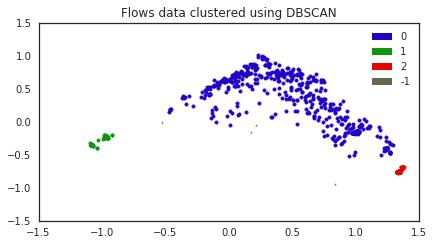

Category id #0 contains 494 flows
                    total_datalen: 3.0-4004.6 (66%)
                     traffic_type: 0 (93%)
                     src_port_cnt: 1 (81%)
                       src_ip_cnt: 1 (85%)
                     dst_port_cnt: 1 (81%)
                        bytes_cnt: 60.0-4191.0 (60%)
Category id #1 contains 256 flows
             std_dev_payload_byte: 0.0 (100%)
                mean_payload_byte: 0.0 (99%)
                       src_ip_cnt: 1 (80%)
                     dst_port_cnt: 1 (94%)
                 max_payload_byte: 0 (99%)
                 min_payload_byte: 0 (99%)
                     traffic_type: 0 (92%)
                     src_port_cnt: 1 (75%)
            std_dev_packet_length: 0.0-0.0 (85%)
                    total_datalen: 0 (96%)
        byte_distribution_entropy: 0.0 (100%)
                      ip_protocol: 6 (100%)
Category id #2 contains 72 flows
                        push_prop: 1.0 (100%)
                     traffic_type: 0 (100%)
 

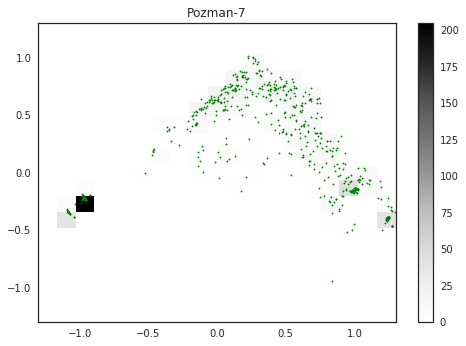

Number of novelity bins is 0
--- Execution time was 8.072762489318848 seconds ---
  Flows scored as DDoS and is DDoS: 0 (Sensivity: 0.00 %)
  Flows scored as non-DDoS and is DDoS: 5646 (FNR: 100.00 %)
  Flows scored as non-DDoS and is not DDoS: 24771 (Specifity: 100.00 %)
  Flows scored as DDoS and is not DDoS: 0 (FPR: 0.00 %)



In [43]:
results = {}
for name, dataset in datasets.items():
    results[name] = detect_ddos(hdfs, datasets, name, features, autoencoder, autoencoder2, mean_hist, std_hist, gen_graphs=False)

In [44]:
from terminaltables import AsciiTable
metrics = ['FPR', 'FNR', 'sensitivity (TPR)', 'specificity (TNR)', 'gmean']
table_data = [[''] + metrics + ['time']]
for traffic, result in results.items():
    row = [traffic] + ["%.2f %%" % result[metric] for metric in metrics]
    row.append('%2.2f sec' % result['time'])
    table_data.append(row)
table = AsciiTable(table_data)
print(table.table)

+-------------------------+---------+----------+-------------------+-------------------+---------+------------+
|                         | FPR     | FNR      | sensitivity (TPR) | specificity (TNR) | gmean   | time       |
+-------------------------+---------+----------+-------------------+-------------------+---------+------------+
| Pozman+SYNflood-HTTP    | 1.82 %  | 23.95 %  | 76.05 %           | 98.18 %           | 86.41 % | 108.40 sec |
| Pozman-2                | 0.00 %  | 100.00 % | 0.00 %            | 100.00 %          | 0.00 %  | 7.34 sec   |
| Pozman-4                | 0.00 %  | 100.00 % | 0.00 %            | 100.00 %          | 0.00 %  | 7.70 sec   |
| Pozman-1                | 0.00 %  | 100.00 % | 0.00 %            | 100.00 %          | 0.00 %  | 10.65 sec  |
| Pozman+RSTflood         | 2.52 %  | 37.93 %  | 62.07 %           | 97.48 %           | 77.79 % | 106.51 sec |
| SYNflood-HTTP-2a        | 0.00 %  | 11.10 %  | 88.90 %           | 0.00 %            | 0.00 %  | 69.29